# Zillow Time Series Modeling: Forecasting Real Estate Value For US Ski Resort Towns

Student name: Tim Rabbitt

Student pace: Self paced

Scheduled project review date/time: 2/15/23 1:00PM

Instructor name: Abhineet Kulkarni

## Overview:
    
A small group of clientele is looking to invest in real estate, members within this group happen to be avid skiers and are particularly interested in real estate that is near a ski resort. While finding suitable real estate near a resort is a main focus, they are hoping that their potential investment is both affordable and forward-thinking. For this project, we will conduct a time series analysis of Zillow's historical average home values in the United States. The goal is to provide the top 5 zip codes, based on projected 3-year return on investment, that is near a ski resort for our clients to consider as investment opportunities.

## Business Understanding:
Our clients offered the following criteria to consider for this project:

1. They would like to invest in an area that is near an attractive resort. This means the resort must have more than 2000 acres of skiable terrain and experience an average of more than 300 inches of annual snowfall.

2. They are not naive as to the price of real estate near most premier ski resorts. They hope to find an investment opportunity 'under the radar'.  Our client's budget is $500,000, applied to the most recent housing data in our dataset (2018).

3. Our clients would like to limit risk by using historical, 5yr, and 3 yr ROI, as well as coefficient of variation of historical housing prices in areas of interest.

By following this criterion for our analysis, we can narrow our focus to only modeling zipcodes that fulfill these requirements. Once those zipcodes are identified, we can perform a time series analysis to find which zip codes project to be the best 3-year investment. 

## Data Understanding:

We used two datasets for our analysis. The first dataset consists of nearly 15,000 zip codes within the United States. This dataset has 14,723 rows and 272 columns. Columns mainly consist of the monthly average home values of each zip code between April 1996 and April 2018. The dataset also provides additional information about each zipcode, such as:
* `RegionID` - Unique ID number. 
* `RegionName` - Zipcode
* `City` - The name of the city in which the Zipcode is located.
* `State` - The name of the State in which the City is located. 
* `Metro` - The name of the Metro region. 
* `CountyName` - The name of the County 
* `SizeRank` - Zipcode’s size ranking relative to other records in the dataset.

The second dataset used for this analysis consists of information on 462 ski resorts in North America. This dataset provides metrics of interest such as average annual snowfall, skiable acreage, the nearest city, and the state the resort is located in. Further information on this dataset can be found at [Kaggle.com](https://www.kaggle.com/datasets/aryanjuyal/comparison-of-north-american-ski-resorts)

* `Resort` - The name of the ski resort
* `City` - Name of closest City                       
* `State` - Name of the State in which the Resort is located                       
* `Peak elevation (ft)` - Peak elevation of Resort         
* `Base elevation (ft)` - Base elevation of Resort        
* `Vertical drop (ft)`  - Difference in peak and base elevation        
* `Skiable acreage` - Total skiable acreage of the Resort             
* `Total trails` - Total number of trails on the Resort                
* `Total lifts` - Total number of lifts on the Resort                 
* `Avg annual snowfall (in)` - Average annual snowfall in inches  
* `Lift ticket (USD)` - Lift ticket price           


By utilizing both datasets we were able to accomplish our clients wishes of filtering zipcodes based on historical average home sales values as well as proximity to attractive ski resorts.

## Data Preprocessing:

In [1]:
# Importing necessary libraries

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline 

#Loading zillow housing data into pandas dataframe
zillow = pd.read_csv('zillow_data.csv')
zillow.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [2]:
# Viewing number of zipcodes in dataset and nan values

print('Total number of zipcodes:', len(zillow))
zillow.iloc[:, :10].isna().sum()

Total number of zipcodes: 14723


RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
dtype: int64

In [3]:
# Viewing total number of Nan values in dataset

zillow.isna().sum().sum()

157934

In [4]:
#Inspecting dataframe dtypes

zillow.iloc[:, :10].dtypes

RegionID        int64
RegionName      int64
City           object
State          object
Metro          object
CountyName     object
SizeRank        int64
1996-04       float64
1996-05       float64
1996-06       float64
dtype: object

Our dataset includes 14723 zip codes. We are missing 1043 entries in our `Metro` column. The data frame as a whole has 157934 Nan values that appear to be particular zipcodes missing average house value data from the late 90s. We will address these missing values at a later time after filtering our data down to desired zip codes. All other metrics are complete entries with no missing data. 

To filter our Zillow dataset according to our client's criteria we will be using the Comparison of the North American Ski Resorts dataset from Kaggle. This dataset consists of 462 ski resorts in North America and provides metrics of interest such as average annual snowfall, skiable acreage, the nearest city, and the state the resort is located in. 

In [5]:
# Importing North American ski resort data into pandas dataframe

resorts = pd.read_csv('north_american_ski_resort_data.csv')
resorts.head()

,Resort,City,State,Peak elevation (ft),Base elevation (ft),Vertical drop (ft),Skiable acreage,Total trails,Total lifts,Avg annual snowfall (in),Lift ticket (USD)
0,Afton Alps,Afton,Minnesota,700,350,350,300,50,22,60,28
1,Pomerelle Mountain Resort,Albion,Idaho,9000,8000,1000,500,24,2,500,45
2,Sandia Peak,Albuquerque,New Mexico,10378,8678,1700,200,39,5,100,55
3,Bear Creek Mountain Resort,Allentown,Pennsylvania,1100,590,510,86,21,7,30,60
4,Grand Targhee Resort,Alta,Wyoming,10121,7851,2270,2602,99,5,500,98


In [6]:
print('Total number of ski resorts:', len(resorts))
resorts.isna().sum()

Total number of ski resorts: 462


Resort                      0
City                        0
State                       0
Peak elevation (ft)         0
Base elevation (ft)         0
Vertical drop (ft)          0
Skiable acreage             0
Total trails                0
Total lifts                 0
Avg annual snowfall (in)    0
Lift ticket (USD)           0
dtype: int64

Our resort data frame looks to be complete, with no Nan values in the dataset.

At this point, we will filter our dataset to only include ski resorts that meet the conditions laid out by our clients. The resort must have at least 2000 skiable acres and experience over 300 inches of annual snowfall.   

In [7]:
# Dropping resorts that do not meet clients conditions

resorts = resorts.drop(resorts[(resorts['Skiable acreage'] < 2000) | 
                               (resorts['Avg annual snowfall (in)'] < 300)].index)
resorts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 4 to 454
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Resort                    33 non-null     object
 1   City                      33 non-null     object
 2   State                     33 non-null     object
 3   Peak elevation (ft)       33 non-null     int64 
 4   Base elevation (ft)       33 non-null     int64 
 5   Vertical drop (ft)        33 non-null     int64 
 6   Skiable acreage           33 non-null     int64 
 7   Total trails              33 non-null     int64 
 8   Total lifts               33 non-null     int64 
 9   Avg annual snowfall (in)  33 non-null     int64 
 10  Lift ticket (USD)         33 non-null     int64 
dtypes: int64(8), object(3)
memory usage: 3.1+ KB


We now have 33 resorts that satisfy those conditions. In order for us to merge our `resorts` and `zillow` dataframes we will first need to change the resort State columns to its respective two letter abbreviations. We will us the `states_dict` below to accomplish this.

In [8]:
# Creating states_dict to map onto resorts dataframe

states_dict = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

# Code credit/reference https://gist.github.com/rogerallen/1583593

In [9]:
# Mapping out state_dict to State column of resort df

resorts['State'] = resorts['State'].map(states_dict)   
print(resorts.info())
resorts.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 4 to 454
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Resort                    33 non-null     object
 1   City                      33 non-null     object
 2   State                     27 non-null     object
 3   Peak elevation (ft)       33 non-null     int64 
 4   Base elevation (ft)       33 non-null     int64 
 5   Vertical drop (ft)        33 non-null     int64 
 6   Skiable acreage           33 non-null     int64 
 7   Total trails              33 non-null     int64 
 8   Total lifts               33 non-null     int64 
 9   Avg annual snowfall (in)  33 non-null     int64 
 10  Lift ticket (USD)         33 non-null     int64 
dtypes: int64(8), object(3)
memory usage: 3.1+ KB
None


,Resort,City,State,Peak elevation (ft),Base elevation (ft),Vertical drop (ft),Skiable acreage,Total trails,Total lifts,Avg annual snowfall (in),Lift ticket (USD)
4,Grand Targhee Resort,Alta,WY,10121,7851,2270,2602,99,5,500,98
17,Snowmass,Aspen,CO,12510,8104,4406,3362,96,17,300,174
21,Sunshine Village,Banff,NaN,8954,5440,3514,3358,107,12,360,82
35,Mt Bachelor,Bend,OR,9065,5700,3365,4318,101,11,462,99
53,Big Sky Resort,Bozeman,MT,11166,6800,4350,5800,317,36,400,170


In [10]:
# Instances where State is Nan in dataset

null_states = resorts[resorts['State'].isnull()]
null_states

,Resort,City,State,Peak elevation (ft),Base elevation (ft),Vertical drop (ft),Skiable acreage,Total trails,Total lifts,Avg annual snowfall (in),Lift ticket (USD)
21,Sunshine Village,Banff,NaN,8954,5440,3514,3358,107,12,360,82
127,Fernie Alpine Resort,Fernie,NaN,7000,3450,3550,2500,142,10,360,90
319,Castle Mountain Resort,Pincher Creek,NaN,7463,4630,2833,3592,94,6,354,71
342,Revelstoke Mountain Resort,Revelstoke,NaN,7300,1680,5620,3121,75,5,413,119
348,Red Mountain Resort,Rossland,NaN,6807,3887,2919,4200,110,7,300,74
444,Whistler Blackcomb,Whistler,NaN,7494,2140,5280,8171,200,26,404,93


Applying our `states_dict` worked well overall, however, there are now 6 Nan values in our State column. These instances involved Canadian ski resorts that did not have an associated state, which makes sense. Our clients are only interested in investing in property within the United States. Let's drop the Canadian ski resorts.

In [11]:
# Dropping Canadian ski resorts from resorts dataset

resorts.dropna(inplace=True)
resorts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 4 to 454
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Resort                    27 non-null     object
 1   City                      27 non-null     object
 2   State                     27 non-null     object
 3   Peak elevation (ft)       27 non-null     int64 
 4   Base elevation (ft)       27 non-null     int64 
 5   Vertical drop (ft)        27 non-null     int64 
 6   Skiable acreage           27 non-null     int64 
 7   Total trails              27 non-null     int64 
 8   Total lifts               27 non-null     int64 
 9   Avg annual snowfall (in)  27 non-null     int64 
 10  Lift ticket (USD)         27 non-null     int64 
dtypes: int64(8), object(3)
memory usage: 2.5+ KB


We now have a dataset that includes 27 ski resorts that satisfy the requirements laid out by our clients. Ultimately we want to do a time series analysis of the zip codes associated with these resorts. To accomplish this we will merge our `resorts` and `Zillow` data frames on shared `City` and `State` entries. 

In [12]:
# Merging zillow and resorts dataframes

resorts_df = pd.merge(zillow, resorts,  how='left', left_on=['City','State'], right_on = ['City','State'])
resorts_df.dropna(inplace=True)
resorts_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-04,Resort,Peak elevation (ft),Base elevation (ft),Vertical drop (ft),Skiable acreage,Total trails,Total lifts,Avg annual snowfall (in),Lift ticket (USD)
135,99142,97229,Portland,OR,Portland,Multnomah,136,209800.0,209700.0,210700.0,...,574800,Mount Hood Meadows,7300.0,4523.0,2777.0,2150.0,85.0,11.0,430.0,79.0
404,100157,99208,Spokane,WA,Spokane,Spokane,405,121200.0,120500.0,119700.0,...,251500,49 Degrees North,5774.0,3923.0,1851.0,2325.0,82.0,6.0,300.0,62.0
450,84241,59901,Kalispell,MT,Kalispell,Flathead,451,130800.0,130900.0,130900.0,...,258700,Whitefish Mountain Resort,6817.0,4464.0,2353.0,3000.0,105.0,14.0,300.0,83.0
644,99120,97206,Portland,OR,Portland,Multnomah,645,96600.0,97600.0,98600.0,...,382200,Mount Hood Meadows,7300.0,4523.0,2777.0,2150.0,85.0,11.0,430.0,79.0
706,99388,97702,Bend,OR,Bend,Deschutes,707,160300.0,160300.0,160300.0,...,411100,Mt Bachelor,9065.0,5700.0,3365.0,4318.0,101.0,11.0,462.0,99.0


In [13]:
print('Length of dataframe:', len(resorts_df))
resorts_df['RegionName'].value_counts()

Length of dataframe: 75


96161    2
84101    2
59715    2
95728    2
84116    2
        ..
97216    1
97215    1
97214    1
97213    1
99201    1
Name: RegionName, Length: 62, dtype: int64

We now have 62 zip codes, however, looking at the `RegionName` value counts there seem to be duplicates of certain zipcodes in our dataset. 

In [14]:
# Investigating instance of duplicate zipcode

resorts_df.loc[resorts_df['RegionName'] == 96161]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-04,Resort,Peak elevation (ft),Base elevation (ft),Vertical drop (ft),Skiable acreage,Total trails,Total lifts,Avg annual snowfall (in),Lift ticket (USD)
6507,98672,96161,Truckee,CA,Truckee,Nevada,6499,199700.0,197400.0,195100.0,...,615900,Northstar California,8610.0,6330.0,2280.0,2904.0,93.0,19.0,350.0,169.0
6508,98672,96161,Truckee,CA,Truckee,Nevada,6499,199700.0,197400.0,195100.0,...,615900,Squaw Valley-Alpine Meadows,9050.0,6200.0,2850.0,6400.0,277.0,43.0,450.0,169.0


Certain zipcodes near multiple resorts satisfy our criteria, as the length of our `resorts_df` indicates. For this project we are mainly interested in zip codes that are near at least one ski area and not multiple ski areas, therefore we will drop duplicate zip codes from our `RegionName` column. This will provide us with unique zip codes that we can move forward with.

In [15]:
# Filtering dataframe to produce unique RegionName values

resorts_df = resorts_df.drop_duplicates('RegionName')
print('Number of unique zipcodes:', len(resorts_df))

Number of unique zipcodes: 62


Now that we have 62 unique zipcodes that are near ski resorts that satisfy our clients requirements of 2000 skiable acres and 300 inches of average snowfall, we can begin filtering our dataset further by removing zipcodes that have a aveerage home value that exceeds our clients budget of $500,000. This budget will be applied to the most recent month in our dataset, April 2018. 

In [16]:
# Removing zipcodes that exceed $500K in April 2018

resorts_df = resorts_df.drop(resorts_df[resorts_df['2018-04'] > 500000].index)
print('Total zipcodes under $500K as of Apr 2018:', len(resorts_df))

Total zipcodes under $500K as of Apr 2018: 40


We have narrowed our focus to 40 zipcodes, from here we will begin looking at each zipcode and its historical, 5-year, and 3-year return on investment. Additionally, our clients would like to limit risk on any potential investment so will use the coefficient of variation (CV) which allows investors to determine how much volatility is assumed in comparison to the amount of return expected from investments.

In [17]:
# Calculating ROI's and CV

## Historical ROI
resorts_df['ROI_hist'] = round((resorts_df['2018-04'] - resorts_df['1996-04'])/ resorts_df['1996-04'],4)
## 5 year ROI
resorts_df['ROI_5yr'] = round((resorts_df['2018-04'] - resorts_df['2013-01'])/ resorts_df['2013-01'],4)
## 3 year ROI
resorts_df['ROI_3yr'] = round((resorts_df['2018-04'] - resorts_df['2015-01'])/ resorts_df['2015-01'],4)

# Define function to calculate CV
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100 

# Calculate CV
resorts_df['CV'] = round((np.std(resorts_df[['1996-04', '2018-04']], axis=1) / 
                    np.mean(resorts_df[['1996-04', '2018-04']], axis=1)),4)

resorts_df.sort_values('CV').head(10)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,Vertical drop (ft),Skiable acreage,Total trails,Total lifts,Avg annual snowfall (in),Lift ticket (USD),ROI_hist,ROI_5yr,ROI_3yr,CV
3066,100156,99207,Spokane,WA,Spokane,Spokane,3064,70000.0,69700.0,69500.0,...,1851.0,2325.0,82.0,6.0,300.0,62.0,0.9500,0.5946,0.5100,0.3220
450,84241,59901,Kalispell,MT,Kalispell,Flathead,451,130800.0,130900.0,130900.0,...,2353.0,3000.0,105.0,14.0,300.0,83.0,0.9778,0.3746,0.3432,0.3284
1432,84149,59718,Bozeman,MT,Bozeman,Gallatin,1433,174800.0,174700.0,174700.0,...,4350.0,5800.0,317.0,36.0,400.0,170.0,0.9874,0.4191,0.3285,0.3305
1132,100154,99205,Spokane,WA,Spokane,Spokane,1133,80400.0,80100.0,79800.0,...,1851.0,2325.0,82.0,6.0,300.0,62.0,1.0522,0.4785,0.3808,0.3447
404,100157,99208,Spokane,WA,Spokane,Spokane,405,121200.0,120500.0,119700.0,...,1851.0,2325.0,82.0,6.0,300.0,62.0,1.0751,0.4716,0.3631,0.3496
5964,100166,99217,Spokane,WA,Spokane,Spokane,5957,86000.0,85700.0,85400.0,...,1851.0,2325.0,82.0,6.0,300.0,62.0,1.0953,0.4451,0.3498,0.3539
2159,84146,59715,Bozeman,MT,Bozeman,Gallatin,2159,212700.0,212700.0,212700.0,...,4350.0,5800.0,317.0,36.0,400.0,170.0,1.0978,0.5423,0.4320,0.3544
2270,100170,99223,Spokane,WA,Spokane,Spokane,2268,136200.0,135700.0,135200.0,...,1851.0,2325.0,82.0,6.0,300.0,62.0,1.1050,0.5074,0.3817,0.3559
4610,94462,84102,Salt Lake City,UT,Salt Lake City,Salt Lake,4606,181600.0,181200.0,180800.0,...,2020.0,2200.0,116.0,10.0,560.0,125.0,1.1801,0.6192,0.4789,0.3711
6058,100150,99201,Spokane,WA,Spokane,Spokane,6051,64400.0,64400.0,64400.0,...,1851.0,2325.0,82.0,6.0,300.0,62.0,1.1894,0.6726,0.5210,0.3729


Using the lowest CV values to determine our top 10 zipcodes, we notice many zip codes are within the same city and are therefore associated with the same resort. To provide more resort investment opportunities for our clients to consider we will instead filter our dataset by identifying unique resorts and then finding the lowest CV value in their associated zip codes. 

In [18]:
# Filtering for lowest CV value and unique resorts

final_df = resorts_df.sort_values('CV').drop_duplicates(['Resort'])
print('Total zipcodes that meet all criteria:', len(final_df))
print('Total Nan values in dataframe:', final_df.isna().sum().sum())
final_df

Total zipcodes that meet all criteria: 10
Total Nan values in dataframe: 0


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,Vertical drop (ft),Skiable acreage,Total trails,Total lifts,Avg annual snowfall (in),Lift ticket (USD),ROI_hist,ROI_5yr,ROI_3yr,CV
3066,100156,99207,Spokane,WA,Spokane,Spokane,3064,70000.0,69700.0,69500.0,...,1851.0,2325.0,82.0,6.0,300.0,62.0,0.9500,0.5946,0.5100,0.3220
450,84241,59901,Kalispell,MT,Kalispell,Flathead,451,130800.0,130900.0,130900.0,...,2353.0,3000.0,105.0,14.0,300.0,83.0,0.9778,0.3746,0.3432,0.3284
1432,84149,59718,Bozeman,MT,Bozeman,Gallatin,1433,174800.0,174700.0,174700.0,...,4350.0,5800.0,317.0,36.0,400.0,170.0,0.9874,0.4191,0.3285,0.3305
4610,94462,84102,Salt Lake City,UT,Salt Lake City,Salt Lake,4606,181600.0,181200.0,180800.0,...,2020.0,2200.0,116.0,10.0,560.0,125.0,1.1801,0.6192,0.4789,0.3711
5099,94359,83864,Sandpoint,ID,Sandpoint,Bonner,5093,105200.0,105200.0,105300.0,...,2400.0,2900.0,92.0,7.0,300.0,86.0,1.4534,0.3339,0.2016,0.4209
1821,99143,97230,Portland,OR,Portland,Multnomah,1821,134700.0,135500.0,136400.0,...,2777.0,2150.0,85.0,11.0,430.0,79.0,1.4744,0.8193,0.4348,0.4244
1447,99387,97701,Bend,OR,Bend,Deschutes,1447,136300.0,136100.0,135900.0,...,3365.0,4318.0,101.0,11.0,462.0,99.0,1.4960,0.9507,0.3685,0.4279
4925,99507,98022,Enumclaw,WA,Seattle,King,4919,155000.0,155000.0,155100.0,...,3100.0,2600.0,57.0,12.0,350.0,96.0,1.6052,0.5854,0.3559,0.4452
5499,98663,96150,South Lake Tahoe,CA,Sacramento,El Dorado,5493,132800.0,132500.0,132400.0,...,3500.0,4800.0,94.0,30.0,360.0,164.0,2.2568,0.6482,0.2573,0.5302
14702,98404,95728,Truckee,CA,Truckee,Nevada,14691,147700.0,147800.0,148100.0,...,2280.0,2904.0,93.0,19.0,350.0,169.0,2.3602,0.4931,0.1373,0.5413


Our final data frame now as 10 zipcodes and their associated resorts that meet all of our client's criteria. Before we begin our modeling process we first need to clean up and organize the data by dropping unwanted columns, reformatting, and changing dtypes.

In [19]:
# Dropping unwanted resort information

final_df = final_df.drop(final_df.iloc[:, -12:-4], axis=1)
final_df.head(10)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,Resort,ROI_hist,ROI_5yr,ROI_3yr,CV
3066,100156,99207,Spokane,WA,Spokane,Spokane,3064,70000.0,69700.0,69500.0,...,131200,133300,134700,135900,136500,49 Degrees North,0.9500,0.5946,0.5100,0.3220
450,84241,59901,Kalispell,MT,Kalispell,Flathead,451,130800.0,130900.0,130900.0,...,247600,249300,252000,255900,258700,Whitefish Mountain Resort,0.9778,0.3746,0.3432,0.3284
1432,84149,59718,Bozeman,MT,Bozeman,Gallatin,1433,174800.0,174700.0,174700.0,...,336800,338500,341400,344900,347400,Big Sky Resort,0.9874,0.4191,0.3285,0.3305
4610,94462,84102,Salt Lake City,UT,Salt Lake City,Salt Lake,4606,181600.0,181200.0,180800.0,...,382100,383200,384400,389900,395900,Alta Ski Area,1.1801,0.6192,0.4789,0.3711
5099,94359,83864,Sandpoint,ID,Sandpoint,Bonner,5093,105200.0,105200.0,105300.0,...,258200,261900,262100,259700,258100,Schweitzer,1.4534,0.3339,0.2016,0.4209
1821,99143,97230,Portland,OR,Portland,Multnomah,1821,134700.0,135500.0,136400.0,...,325100,327800,330700,332900,333300,Mount Hood Meadows,1.4744,0.8193,0.4348,0.4244
1447,99387,97701,Bend,OR,Bend,Deschutes,1447,136300.0,136100.0,135900.0,...,329200,330400,332600,336700,340200,Mt Bachelor,1.4960,0.9507,0.3685,0.4279
4925,99507,98022,Enumclaw,WA,Seattle,King,4919,155000.0,155000.0,155100.0,...,396700,401400,403800,404300,403800,Crystal Mountain,1.6052,0.5854,0.3559,0.4452
5499,98663,96150,South Lake Tahoe,CA,Sacramento,El Dorado,5493,132800.0,132500.0,132400.0,...,412900,417500,422700,428200,432500,Heavenly Mountain Resort,2.2568,0.6482,0.2573,0.5302
14702,98404,95728,Truckee,CA,Truckee,Nevada,14691,147700.0,147800.0,148100.0,...,482600,480900,483600,490500,496300,Northstar California,2.3602,0.4931,0.1373,0.5413


## EDA and Visualization



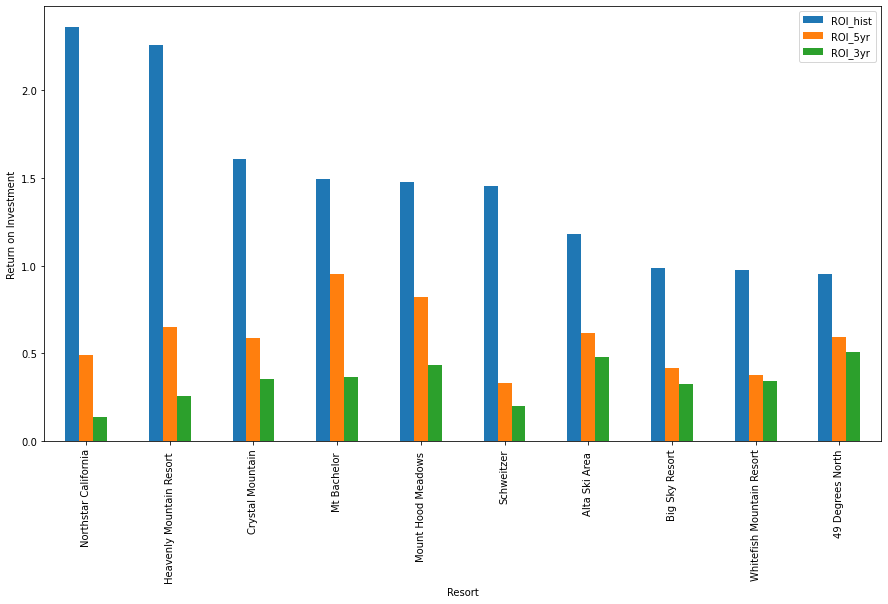

In [20]:
import matplotlib.pyplot as plt

#Plotting historical, 5yr, and 3yr ROI for choosen zipcodes

%matplotlib inline
final_df.sort_values('ROI_hist', ascending=False).plot.bar(x='Resort', y=['ROI_hist', 'ROI_5yr', 'ROI_3yr'], 
                     figsize=(15, 8), xlabel='Resort', ylabel='Return on Investment');

### Plot Observations:

1. The plot above is sorted by historical ROI. Northstar California has seen the highest historical ROI while 49 Degrees North has seen the lowest historical ROI. 

2. While resorts including Northstar California, Heavenly Mountain Resort, and Crystal Mountain have the highest historical ROI, resorts such as Mt. Bachelor, Mount Hood Meadows, and Alta Ski Area have seen higher 5-year and 3-year ROIs, suggesting these resorts and their zipcodes have seen increased demand in recent years. 


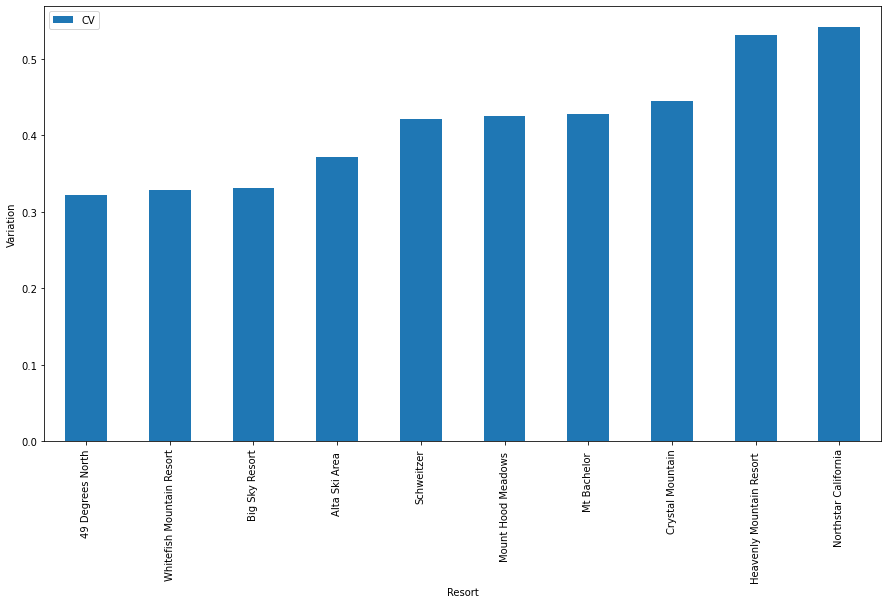

In [21]:
# Plotting co-efficient of variation for choosen zipcodes

final_df.sort_values('CV', ascending=True).plot.bar(x='Resort', y='CV', figsize=(15, 8), 
                  xlabel='Resort', ylabel='Variation');

### Plot Observations:

1. Plotting the coefficient of variation for each resort zip code shows an inverse relationship with our historical ROI graph above. This makes sense, more volatility in home value around the mean brings the potential for a higher return on investment, as well as more risk. 

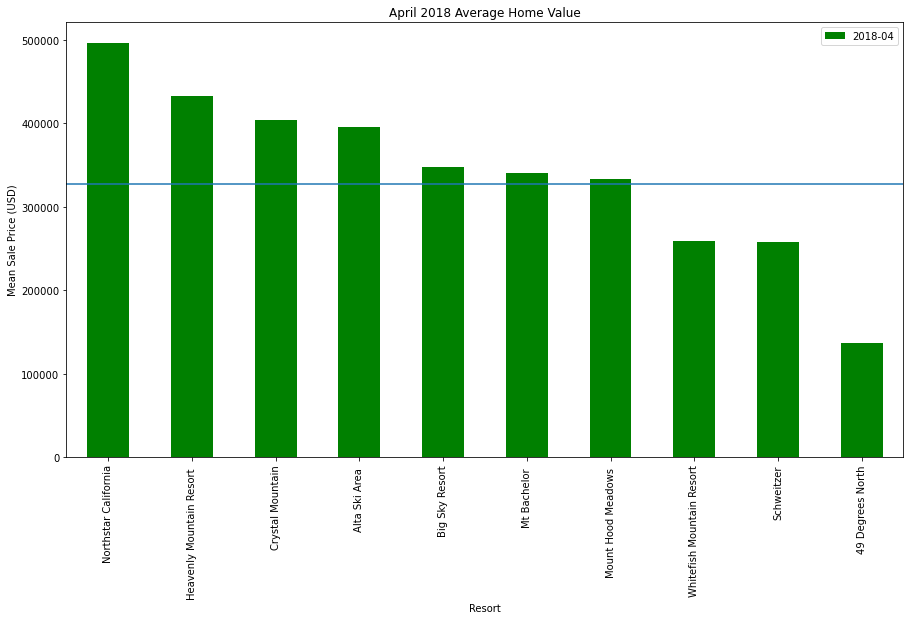

In [22]:
final_df.sort_values('2018-04', ascending=False).plot.bar(x='Resort', y='2018-04', figsize=(15, 8), xlabel='Resort', 
                  ylabel = 'Mean Sale Price (USD)', color='green', title='April 2018 Average Home Value')
plt.axhline(resorts_df['2018-04'].mean(), label='Average Home Value for Qualified Resort Zipcodes');

In [23]:
final_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,Resort,ROI_hist,ROI_5yr,ROI_3yr,CV
3066,100156,99207,Spokane,WA,Spokane,Spokane,3064,70000.0,69700.0,69500.0,...,131200,133300,134700,135900,136500,49 Degrees North,0.9500,0.5946,0.5100,0.3220
450,84241,59901,Kalispell,MT,Kalispell,Flathead,451,130800.0,130900.0,130900.0,...,247600,249300,252000,255900,258700,Whitefish Mountain Resort,0.9778,0.3746,0.3432,0.3284
1432,84149,59718,Bozeman,MT,Bozeman,Gallatin,1433,174800.0,174700.0,174700.0,...,336800,338500,341400,344900,347400,Big Sky Resort,0.9874,0.4191,0.3285,0.3305
4610,94462,84102,Salt Lake City,UT,Salt Lake City,Salt Lake,4606,181600.0,181200.0,180800.0,...,382100,383200,384400,389900,395900,Alta Ski Area,1.1801,0.6192,0.4789,0.3711
5099,94359,83864,Sandpoint,ID,Sandpoint,Bonner,5093,105200.0,105200.0,105300.0,...,258200,261900,262100,259700,258100,Schweitzer,1.4534,0.3339,0.2016,0.4209


In [24]:
final_df2 = final_df.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'Resort', 'ROI_hist', 
                          'ROI_5yr', 'ROI_3yr', 'CV'], axis=1)
final_df2.head()

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
3066,99207,70000.0,69700.0,69500.0,69200.0,69000.0,68700.0,68400.0,68200.0,68100.0,...,123400,125300,126800,127800,129200,131200,133300,134700,135900,136500
450,59901,130800.0,130900.0,130900.0,131000.0,131000.0,131100.0,131100.0,131000.0,131000.0,...,238400,240200,242100,244000,245900,247600,249300,252000,255900,258700
1432,59718,174800.0,174700.0,174700.0,174700.0,174800.0,174900.0,175000.0,175100.0,175200.0,...,327100,328300,330300,333000,335200,336800,338500,341400,344900,347400
4610,84102,181600.0,181200.0,180800.0,180300.0,179800.0,179300.0,178800.0,178300.0,178000.0,...,362900,366900,369300,373000,378500,382100,383200,384400,389900,395900
5099,83864,105200.0,105200.0,105300.0,105500.0,105900.0,106300.0,106900.0,107700.0,108600.0,...,256700,256000,249600,246300,251300,258200,261900,262100,259700,258100


## Reshape from Wide to Long Format

In [25]:
ts_df = final_df2.melt(id_vars='RegionName', var_name='Time', value_name='Sale Price')
ts_df['Time'] = pd.to_datetime(ts_df['Time'], infer_datetime_format=True)
ts_df.set_index('Time', inplace=True)
ts_df = ts_df.pivot_table('Sale Price', ['Time'], 'RegionName')
ts_df.tail()

RegionName,59718,59901,83864,84102,95728,96150,97230,97701,98022,99207
Time,,,,,,,,,,
2017-12-01,336800.0,247600.0,258200.0,382100.0,482600.0,412900.0,325100.0,329200.0,396700.0,131200.0
2018-01-01,338500.0,249300.0,261900.0,383200.0,480900.0,417500.0,327800.0,330400.0,401400.0,133300.0
2018-02-01,341400.0,252000.0,262100.0,384400.0,483600.0,422700.0,330700.0,332600.0,403800.0,134700.0
2018-03-01,344900.0,255900.0,259700.0,389900.0,490500.0,428200.0,332900.0,336700.0,404300.0,135900.0
2018-04-01,347400.0,258700.0,258100.0,395900.0,496300.0,432500.0,333300.0,340200.0,403800.0,136500.0


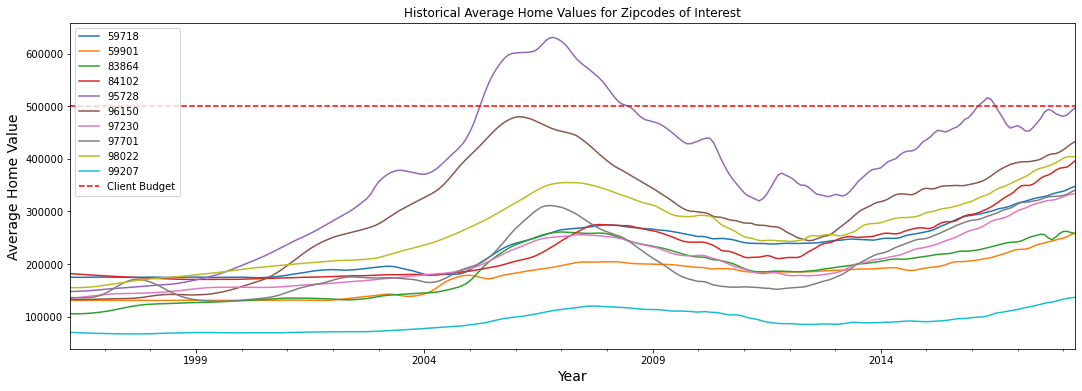

In [26]:
ts_df.plot(figsize=(18,6))
plt.axhline(500000, color = 'r', linestyle = 'dashed', label='Client Budget')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Home Value', fontsize=14)
plt.title('Historical Average Home Values for Zipcodes of Interest')
plt.legend();

Looking at the time series plot above we see the housing market crash of 2008. Historical data prior to that does not represent todays trends and may skew our data. Lets look at a more recent window to see if that time series data is more stable. 

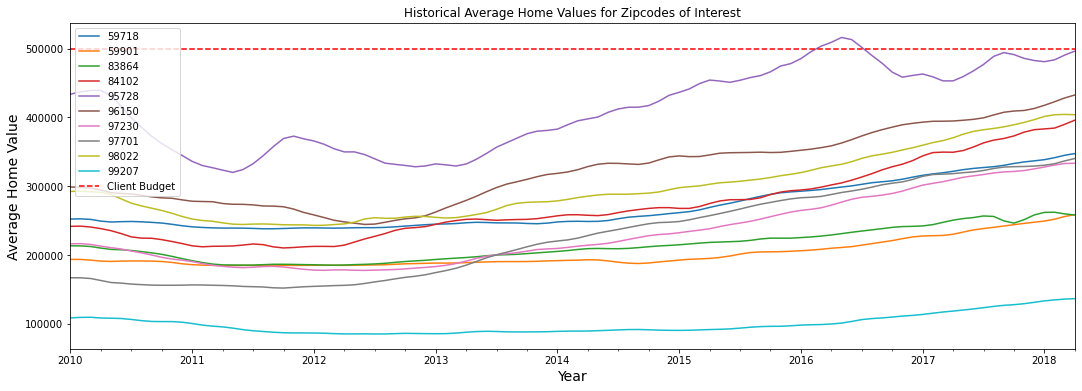

In [27]:
ts_recent = ts_df['2010-01-01':]
ts_recent.plot(figsize=(18,6))
plt.axhline(500000, color = 'r', linestyle = 'dashed', label='Client Budget')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Home Value', fontsize=14)
plt.title('Historical Average Home Values for Zipcodes of Interest')
plt.legend();

This plot appears to be a more accurate depiction of where the housing market is and will better help us to forecast future home value. Therefore, in our modeling process, we will be analyzing our zipcodes using dates after 2010.

Looking at the time series above there appears to be no obvious seasonality. Before we begin our ARIMA modeling, lets try to confirm this by using seasonal decomposition on each zip code. 

In [28]:
# Converting 
ts_recent.columns = ts_recent.columns.astype(str)
zipcode_list =  ts_df.columns.astype(str)

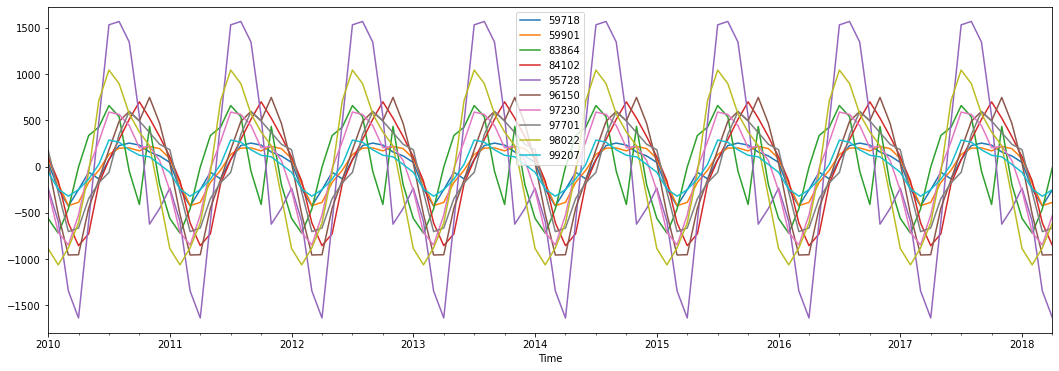

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

for zipcode in zipcode_list:
    decomposition = sm.tsa.seasonal_decompose(ts_recent[zipcode], model='additive')
    seasonal = decomposition.seasonal
    seasonal.plot(figsize=(18,6), label=zipcode)
    plt.legend(loc='best')

The plot above shows there is annual seasonality associated with each of our time series, we will have to keep this in mind moving forward. 

## SARIMA Modeling

For our time series modeling and forecasting, we decided to use a SARIMA model. ARIMA and SARIMA are both algorithms for forecasting. ARIMA takes into account the past values (autoregressive, moving average) and predicts future values based on that. SARIMA similarly uses past values but also takes into account any seasonality patterns. Because seasonality was observed in our decomposition plot above, we thought a SARIMA model would be best to use generate forecasted home values.

## Zipcode 59718: Big Sky Resort

We are ready to begin the modeling process on our first zipcode, 59718. We first need to find our optimal parameters for the SARIMA model, finding these parameters can be rather complex when modeling 10 zip codes. To help with this process we will create a grid search function that optimizes for a particular criterion, in this case AIC (Akaike Information Criteria), and returns the SARIMA model which minimizes the value.

By splitting our time series into a train and test sets, we can optimize our model parameters on our train data and forecast values against our test data. Using root mean squared error (RMSE) we can assess our model's performance in capturing the time series.

In [30]:
# Importing necessary libraries

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [31]:
# Identifying range for pdq values
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [32]:
warnings.filterwarnings("ignore")

ts = ts_recent['59718']
    
# Train Test Split
train_size=0.8
split_indx = round(len(ts) * train_size)
train = ts[:split_indx]
test = ts[split_indx:]

# Find lowest AIC for pdq/pdqs combinations
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
        except:
            continue
            
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic            830.03
Name: 63, dtype: object

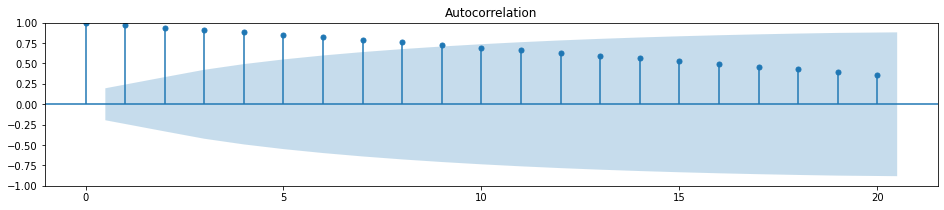

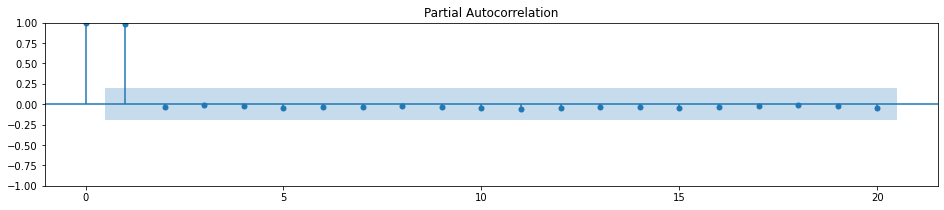

In [33]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(ts, ax=ax, lags=20);
    
fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(ts, ax=ax, lags=20);   

Our grid search that had the best fit, or lowest AIC score, had an order of (1,1,1) and seasonal order of (1,1,1,12). These orders should be the optimal parameters for our SARIMA model. Once we have fit our model to our train data we can test its performance by predicting housing prices between 09/2016 and 04/2018 (our test data).

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7427      0.077      9.619      0.000       0.591       0.894
ma.L1          0.6690      0.095      7.068      0.000       0.483       0.854
ar.S.L12       0.0255      0.013      1.947      0.051      -0.000       0.051
ma.S.L12      -0.2988      0.079     -3.785      0.000      -0.454      -0.144
sigma2      2.483e+05   5.25e+04      4.726      0.000    1.45e+05    3.51e+05


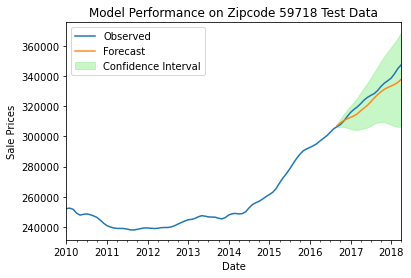

In [34]:
# Plugging optimal parameters into SARIMA model

SARIMA_MODEL = sm.tsa.statespace.SARIMAX(train, 
                order=(1,1,1), 
                seasonal_order=(1,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False)

output = SARIMA_MODEL.fit()

print(output.summary().tables[1])
plt.show()

# Getting test set predictions and confidence intervals from 09/2016 to 04/2018

preds = output.get_prediction(start=pd.to_datetime('2016-09-01'), end=pd.to_datetime('2018-04-01'), dynamic=True) 
pred_conf = preds.conf_int()

# Plot observed values
ax = ts.plot(label='Observed')

# Plot predicted values
preds.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='lightgreen', alpha=0.5, label='Confidence Interval')

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Prices')
ax.set_title('Model Performance on Zipcode 59718 Test Data')
plt.legend()

plt.show()

In [35]:
# Assessing model performance

from sklearn.metrics import mean_squared_error

test_pred = output.get_prediction(start=pd.to_datetime('2016-09-01'), end=pd.to_datetime('2018-04-01'), dynamic=True) 
test_pred_conf = test_pred.conf_int()

test_preds = test_pred.predicted_mean

test_actual = test
test_rmse = np.sqrt(mean_squared_error(test_preds, test_actual))

print('The RMSE of our test predictions is {}'.format(round(test_rmse, 2)))

The RMSE of our test predictions is 4845.41


Our model projection on our test data followed the actual time series quite accurately with an RMSE of $4845. All of our AR and MA terms were statistically significant with a p-value <0.05. The next step is to fit our SARIMA model to our entire time series and use that to predict house prices beyond 2018.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6194      0.107      5.768      0.000       0.409       0.830
ma.L1          1.2664      0.121     10.507      0.000       1.030       1.503
ar.S.L12       0.0248      0.013      1.962      0.050    2.56e-05       0.050
ma.S.L12      -0.2386      0.082     -2.920      0.004      -0.399      -0.078
sigma2      2.594e+05   8.56e+04      3.030      0.002    9.16e+04    4.27e+05


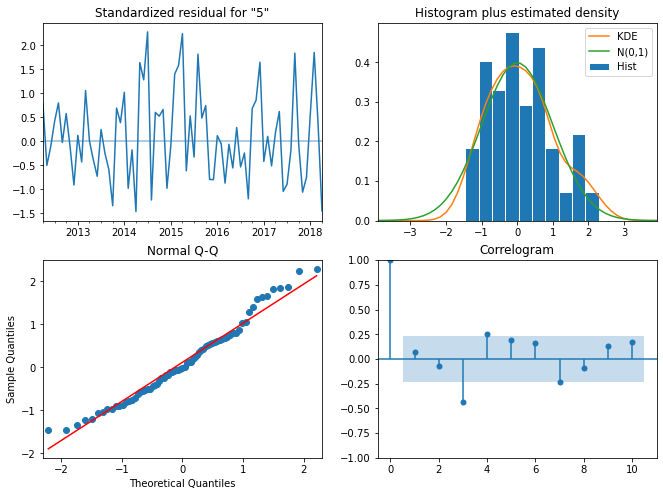

In [36]:
#Plugging optimal parameter and fitting to entire time series

ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts, 
                order=(1,1,1), 
                seasonal_order=(1,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

# Viewing plot diagnostics

print(output.summary().tables[1])
output.plot_diagnostics(figsize=(11,8))
plt.show()

Ideally the plots above should confirm that our residuals are normally distributed and have no correlation between them.  

**Top left:** This plot should show white noise, meaning our residual errors fluctuate around the mean of zero with uniform variance. While the mean of our residuals does appear to be zero there is slight nonuniform variance.

**Top Right:** Our density plot mirrors the N(0,1) line which is the notation for standard normal distribution. This suggests that our residuals are normally distributed.

**Bottom Left:** The qq-plot shows that our residuals are following a linear trend, again suggesting they are normally distributed. 

**Bottom Right:** The correlogram shows some correlation between the residuals and their lagged versions. This could be due to exogenous variables that our model is not accounting for. Future analysis could consider including these features in the modeling process. For this project we will us the current model for forecasting.

These observations lead us to conclude that our model provides a satisfactory fit to help forecast future values. Let's begin forecasting future home value.

Projected 3 year ROI: 0.205


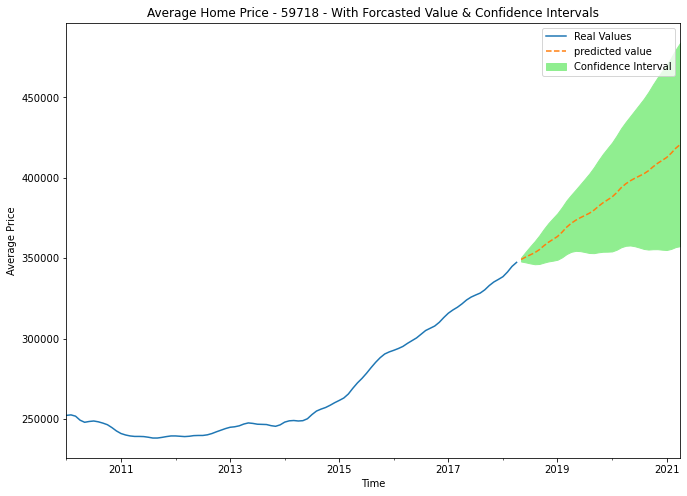

In [37]:
#3 year forcast

forecast = output.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction']
future_prediction['prediction'].plot(ax=ax, label='predicted value',ls='--')

# 3 year ROI
three_year_ROI = round((future_prediction['prediction'][-1] - future_prediction['prediction'][0])/ future_prediction['prediction'][0],4)
print('Projected 3 year ROI:', three_year_ROI)


# Plotting forecast

fig, ax = plt.subplots()

ts.plot(ax=ax, label='Real Values', figsize=(11,8))
future_prediction['prediction'].plot(ax=ax, label='predicted value',ls='--')
ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightgreen',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 59718 - With Forcasted Value & Confidence Intervals')
plt.show()

Our model forecasts zipcode 59718 to have a 3-year return on investment of 20%. 


Now that we have created a model and found an iterative approach that works to predict house sales in zipcode 59718, let's build some functions that will help us analyze the rest of our chosen zipcodes.

In [38]:
# Creating empty list to store analytical results
results = []
results.append(['59718', three_year_ROI])

In [39]:
# Creating function to plot acf and pacf 

def plot_acf_pacf(zipcode):
    print('Time Series Analysis of Zipcode {}'.format(zipcode))
    
    ts = ts_recent[zipcode].copy()
    
    fig, ax = plt.subplots(figsize=(16,3))
    plot_acf(ts, ax=ax, lags=40);
    
    fig, ax = plt.subplots(figsize=(16,3))
    plot_pacf(ts, ax=ax, lags=40);   

In [40]:
def run_sarima(zipcode):
    ts = ts_recent[zipcode]
    
# Train Test Split
    train_size=0.8
    split_indx = round(len(ts) * train_size)
    train = ts[:split_indx]
    test = ts[split_indx:]

# Generating optimal pdq and pdqs orders
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue
            
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

    print(ans_df.loc[ans_df['aic'].idxmin()])
    pdq_order = ans_df.loc[ans_df['aic'].idxmin()][0]
    pdqs_order = ans_df.loc[ans_df['aic'].idxmin()][1]

# Plugging optimal parameters into SARIMA model

    SARIMA_MODEL = sm.tsa.statespace.SARIMAX(train, 
                    order=pdq_order, 
                    seasonal_order=pdqs_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

    output = SARIMA_MODEL.fit()

    print(output.summary().tables[1])
    plt.show()
    
# Getting test set predictions and confidence intervals from 09/2016 to 04/2018

    preds = output.get_prediction(start=pd.to_datetime('2016-09-01'), end=pd.to_datetime('2018-04-01'), dynamic=True) 
    pred_conf = preds.conf_int()

# Plot observed values
    ax = ts.plot(label='Observed')

# Plot predicted values
    preds.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.9)

# Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='lightgreen', alpha=0.5, label='Confidence Interval')

# Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Home ')
    ax.set_title('Model Performance on Zipcode {} Test Data'.format(zipcode))
    plt.legend()
    plt.show()

# Calculating RMSE    
    test_preds = preds.predicted_mean
    test_actual = test

    test_rmse = np.sqrt(mean_squared_error(test_preds, test_actual))
    print('The RMSE of our test predictions is {}'.format(round(test_rmse, 2)))
    
#Plugging optimal parameter and fitting to entire time series

    SARIMA_MODEL2 = sm.tsa.statespace.SARIMAX(ts, 
                order=pdq_order, 
                seasonal_order=pdqs_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

    output2 = SARIMA_MODEL2.fit()

# Viewing plot diagnostics

    print(output2.summary().tables[1])
    output2.plot_diagnostics(figsize=(11,8))
    plt.show()
    
#3 year forecast

    forecast = output2.get_forecast(36)
    future_prediction = forecast.conf_int()
    future_prediction['value'] = forecast.predicted_mean
    future_prediction.columns = ['lower','upper','prediction']
    future_prediction['prediction'].plot(ax=ax, label='predicted value',ls='--')

# 3 year ROI
    three_year_ROI = round((future_prediction['prediction'][-1] - future_prediction['prediction'][0])/ future_prediction['prediction'][0],4)
    print('Projected 3 year ROI:', three_year_ROI)


# Plotting forecast

    fig, ax = plt.subplots()

    ts.plot(ax=ax, label='Real Values', figsize=(15,8))
    future_prediction['prediction'].plot(ax=ax, label='predicted value',ls='--')
    ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightpink',
                label='Confidence Interval')
    ax.legend() 
    plt.ylabel("Average Home Value")
    plt.title('Average Home Value - {} - With Forcasted Value & Confidence Intervals'.format(zipcode))
    plt.show()
    
# Save Results

    results.append([zipcode, three_year_ROI])

In [41]:
# Creating a function to streamline procedure

def analyze_zipcode(zipcode):
    plot_acf_pacf(zipcode)
    run_sarima(zipcode)

## Zipcode 59901: Whitefish Mountain Resort

Time Series Analysis of Zipcode 59901
pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           821.237
Name: 59, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7321      0.067     10.906      0.000       0.601       0.864
ma.L1          0.5888      0.093      6.330      0.000       0.406       0.771
ma.S.L12      -0.1819      0.100     -1.822      0.068      -0.378       0.014
sigma2      2.441e+05   5.01e+04      4.874      0.000    1.46e+05    3.42e+05


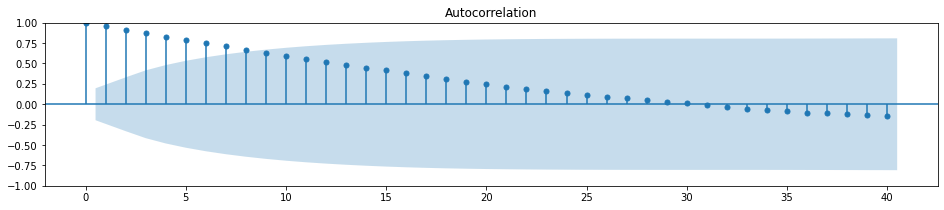

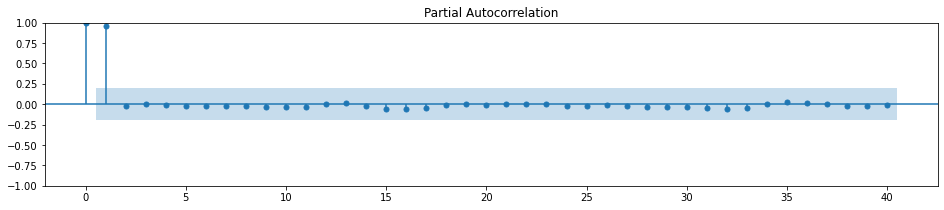

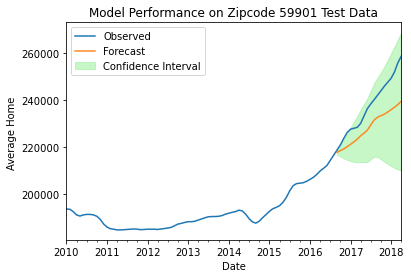

The RMSE of our test predictions is 10198.57
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6392      0.062     10.262      0.000       0.517       0.761
ma.L1          0.6419      0.096      6.660      0.000       0.453       0.831
ma.S.L12      -0.1814      0.088     -2.053      0.040      -0.355      -0.008
sigma2      3.573e+05   5.92e+04      6.037      0.000    2.41e+05    4.73e+05


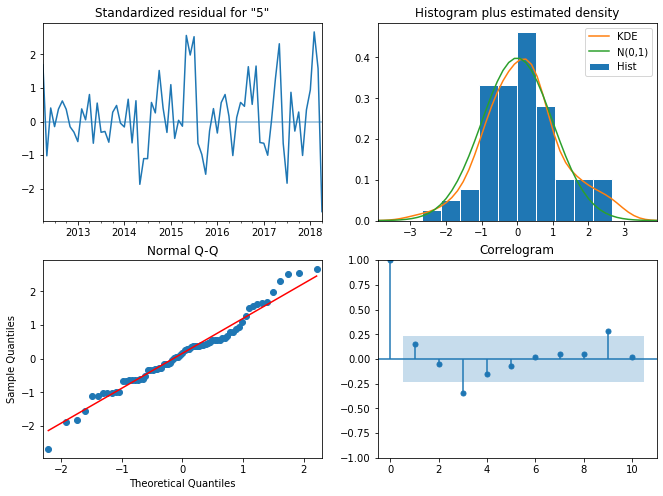

Projected 3 year ROI: 0.2906


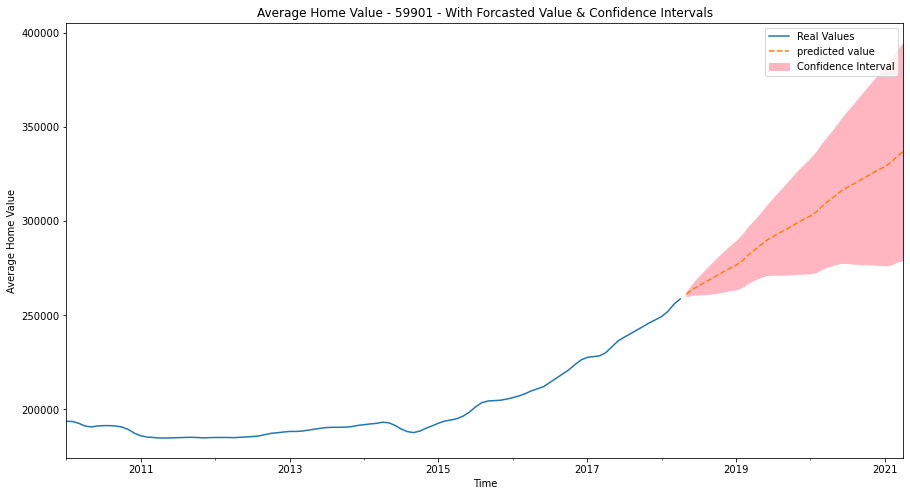

In [42]:
# Analyzing zipcode 59901

analyze_zipcode('59901')

### Zipcode 59901 Analysis Observations:
* Plot diagnostics show our model has adequately captured the time series data. Our residuals show a mean of zero with uniform variance. Additionally, our density plot and Q-Q plot indicate that our residuals follow a normal distribution. Our correlogram does show correlation between the residuals and their lagged versions indicating there could be exogenous factors our model is not accounting for.


* An RMSE of $10,198 isn't stellar but it is adequate as our model accurately predicts overall trend and the actual values in the time series are captured within our confidence intervals.


* Projected 3 year ROI: **29 percent**

## Zipcode 99207: 49 Degrees North


Time Series Analysis of Zipcode 99207
pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           791.704
Name: 59, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7206      0.093      7.734      0.000       0.538       0.903
ma.L1          0.5991      0.100      5.985      0.000       0.403       0.795
ma.S.L12      -0.2731      0.084     -3.237      0.001      -0.439      -0.108
sigma2      1.448e+05   3.18e+04      4.552      0.000    8.25e+04    2.07e+05


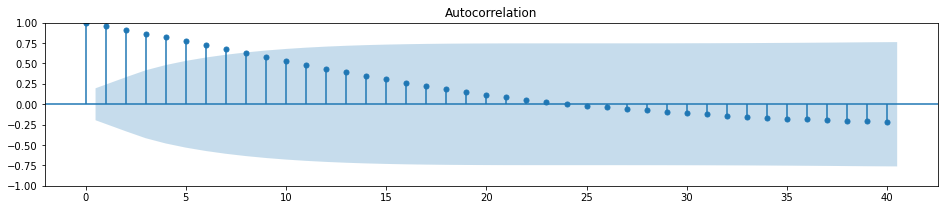

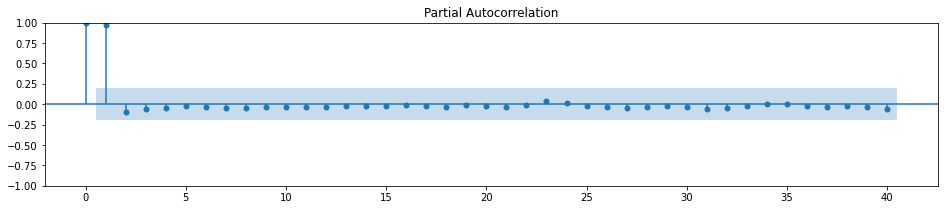

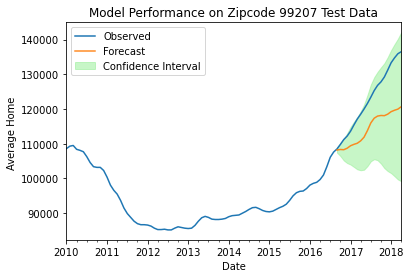

The RMSE of our test predictions is 9512.38
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6964      0.088      7.891      0.000       0.523       0.869
ma.L1          0.6077      0.077      7.882      0.000       0.457       0.759
ma.S.L12      -0.3839      0.073     -5.258      0.000      -0.527      -0.241
sigma2      1.511e+05   2.82e+04      5.366      0.000    9.59e+04    2.06e+05


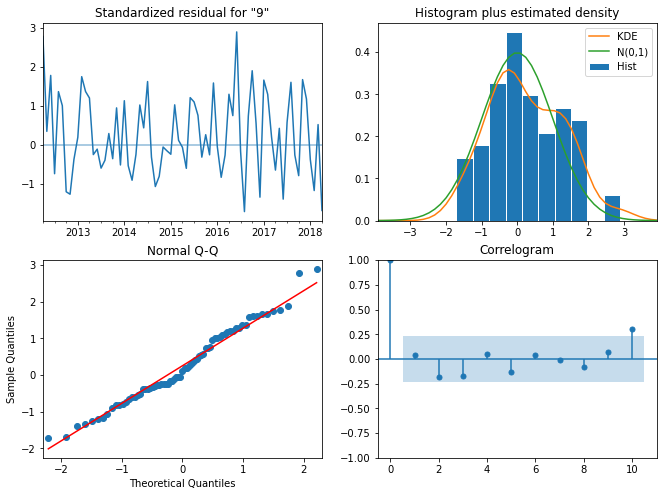

Projected 3 year ROI: 0.3139


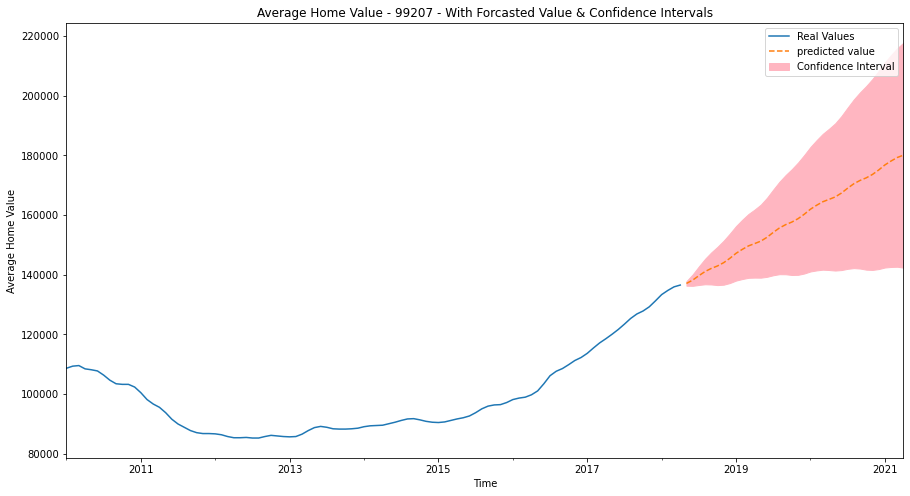

In [43]:
# Analyzing zipcode 99207

analyze_zipcode('99207')

### Zipcode 99207 Analysis Observations:
* Plot diagnostics show our model has adequately captured the time series data. Our residuals show a mean of zero with uniform variance. Additionally, our density plot and Q-Q plot indicate that our residuals nearly follow a normal distribution. Our correlogram does show correlation between the residuals and their lagged versions indicating there could be exogenous factors our model is not accounting for.


* An RMSE of $9512 isn't stellar but it is adequate as our model accurately predicts overall trend and the actual values in the time series are captured within our confidence intervals.


* Projected 3 year ROI: **31 percent**


## Zipcode 84102: Alta Ski Area

Time Series Analysis of Zipcode 84102
pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           919.484
Name: 63, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6626      0.143      4.629      0.000       0.382       0.943
ma.L1          0.7971      0.118      6.744      0.000       0.565       1.029
ar.S.L12       0.1017      0.031      3.242      0.001       0.040       0.163
ma.S.L12      -0.2636      0.088     -3.005      0.003      -0.435      -0.092
sigma2      2.013e+06   3.32e-09   6.07e+14      0.000    2.01e+06    2.01e+06


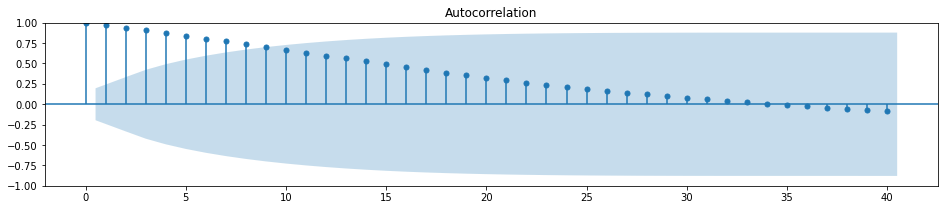

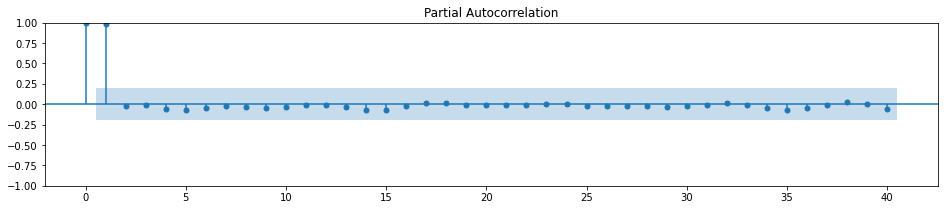

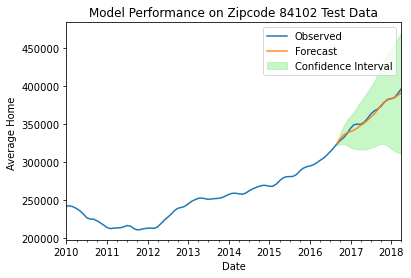

The RMSE of our test predictions is 3136.58
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4730      0.144      3.282      0.001       0.191       0.755
ma.L1          1.1507      0.057     20.301      0.000       1.040       1.262
ar.S.L12       0.1129      0.026      4.382      0.000       0.062       0.163
ma.S.L12      -0.2458      0.083     -2.944      0.003      -0.409      -0.082
sigma2      2.192e+06   1.56e-08   1.41e+14      0.000    2.19e+06    2.19e+06


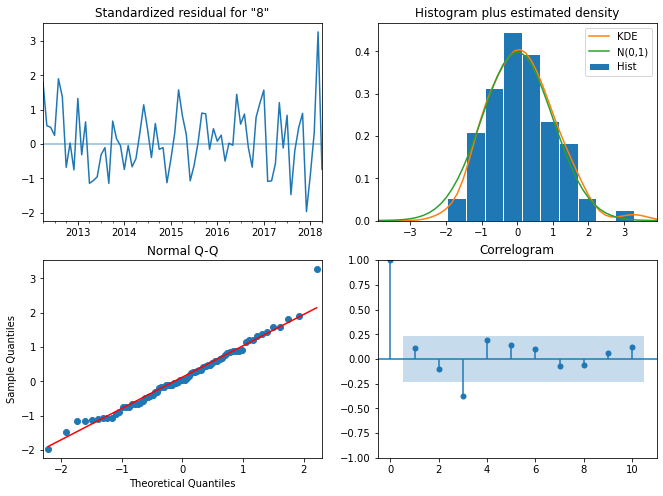

Projected 3 year ROI: 0.3548


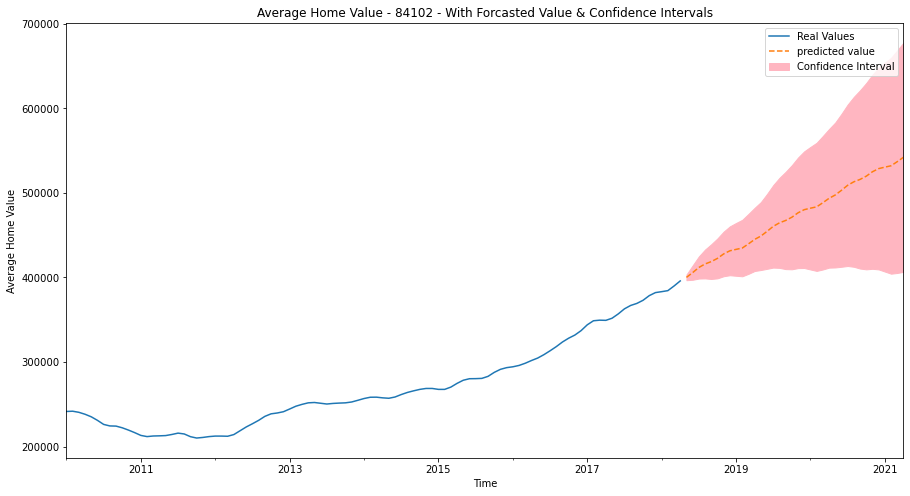

In [44]:
# Analying zipcode 84102

analyze_zipcode('84102')

### Zipcode 84102 Analysis Observations:

* Plot diagnostics show our model has adequately captured the time series data. Our residuals show a mean of zero with uniform variance. Additionally, our density plot and Q-Q plot indicate that our residuals nearly follow a normal distribution. Our correlogram does show correlation between the residuals and their lagged versions indicating there could be exogenous factors our model is not accounting for.


* An RMSE of $3136 indicates our model was pretty accurate in predicting overall trend. Thee actual values in the time series were captured well within our confidence intervals.


* Projected 3 year ROI: **35 percent**

## Zipcode 98022: Crystal Mountain

Time Series Analysis of Zipcode 98022
pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           916.962
Name: 59, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5057      0.130      3.882      0.000       0.250       0.761
ma.L1          0.7732      0.134      5.766      0.000       0.510       1.036
ma.S.L12       0.0727      0.098      0.741      0.459      -0.120       0.265
sigma2      1.632e+06   2.46e+05      6.644      0.000    1.15e+06    2.11e+06


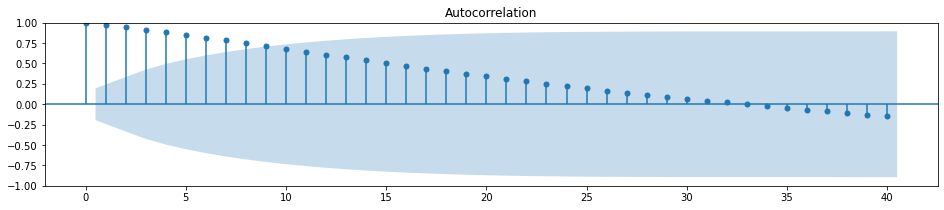

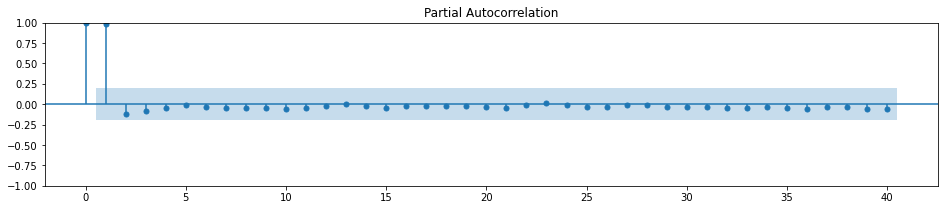

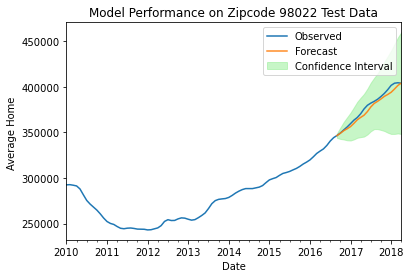

The RMSE of our test predictions is 4028.34
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5115      0.108      4.742      0.000       0.300       0.723
ma.L1          0.7625      0.121      6.321      0.000       0.526       0.999
ma.S.L12       0.0496      0.077      0.645      0.519      -0.101       0.200
sigma2      1.549e+06   2.06e+05      7.514      0.000    1.15e+06    1.95e+06


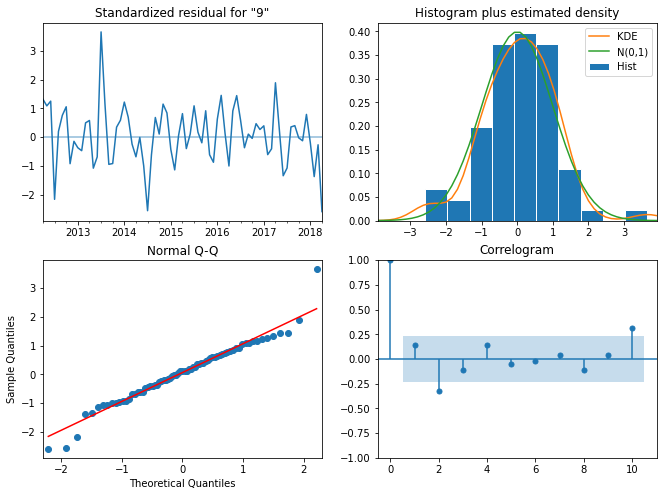

Projected 3 year ROI: 0.1681


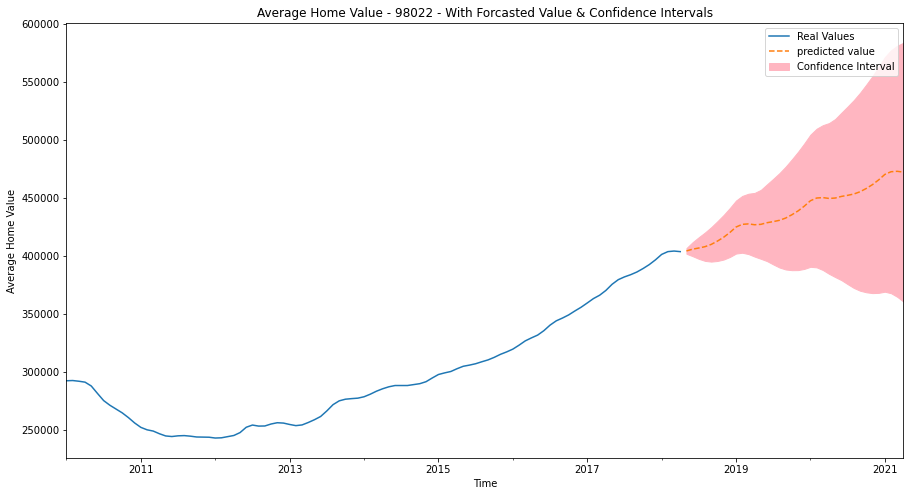

In [45]:
analyze_zipcode('98022')

### Zipcode 98022 Analysis Observations:

* Plot diagnostics show our model has adequately captured the time series data. Our residuals show a mean of zero with uniform variance. Additionally, our density plot and Q-Q plot indicate that our residuals follow a normal distribution. Our correlogram shows some correlation with our residuals and their lagged values.


* Model projection on our test data, with an RMSE of $4028, shows it was pretty accurate. All actual time series values were captured in our confidence interval.

* Projected 3-year ROI: **17 percent**

## Zipcode 96150: Heavenly Mountain Resort

Time Series Analysis of Zipcode 96150
pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           923.695
Name: 63, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8196      0.152      5.377      0.000       0.521       1.118
ma.L1          0.6977      0.152      4.603      0.000       0.401       0.995
ar.S.L12       0.1695      0.063      2.710      0.007       0.047       0.292
ma.S.L12      -0.3005      0.097     -3.099      0.002      -0.491      -0.110
sigma2      2.396e+06   7.22e-09   3.32e+14      0.000     2.4e+06     2.4e+06


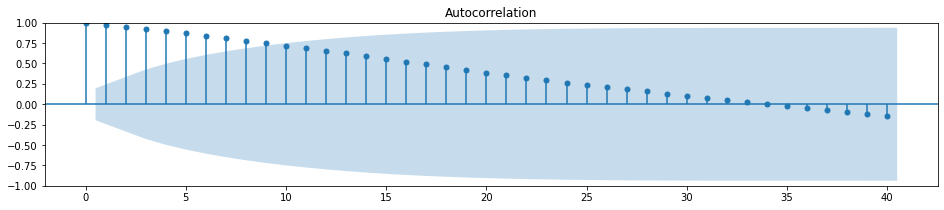

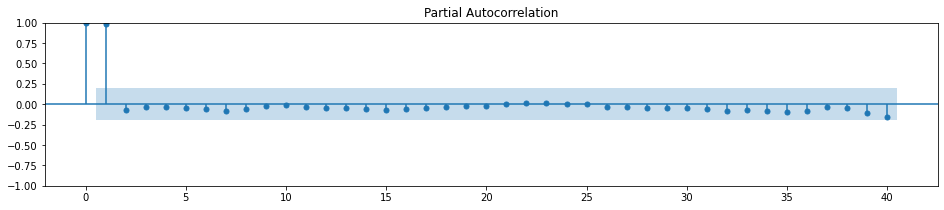

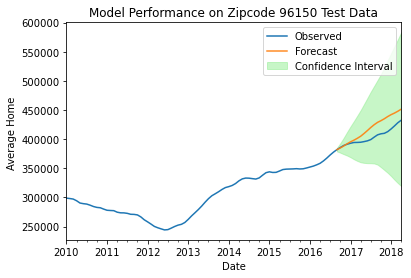

The RMSE of our test predictions is 16819.71
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7968      0.126      6.304      0.000       0.549       1.045
ma.L1          0.6894      0.133      5.203      0.000       0.430       0.949
ar.S.L12       0.1706      0.055      3.124      0.002       0.064       0.278
ma.S.L12      -0.3190      0.089     -3.602      0.000      -0.493      -0.145
sigma2      2.196e+06    7.2e-09   3.05e+14      0.000     2.2e+06     2.2e+06


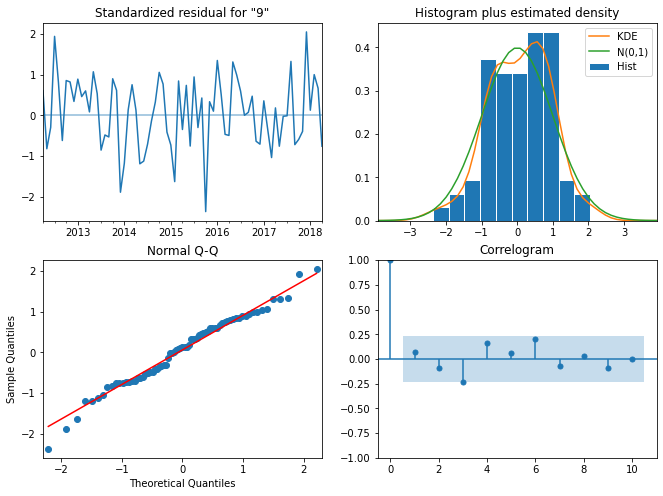

Projected 3 year ROI: 0.3057


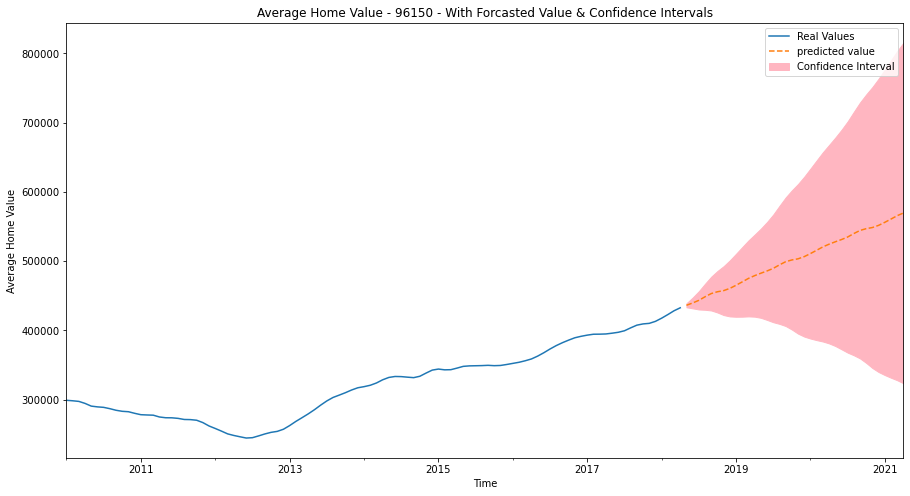

In [46]:
# Analyzing zipcode 96150

analyze_zipcode('96150')

### Zipcode 96150 Analysis Observations:

* Plot diagnostics show our model has adequately captured the time series data. Our residuals have a mean of zero, uniform variance. Our density plot and Q-Q plot indicate that our residuals follow a normal distribution. Our correlogram does not show correlation between the residuals and their lagged versions, which is great.


* Model projection on our test data, with a RMSE of $16,819, was not a perfect fit but does capture the upward trend of the time series. Additionally, the actual values of our test data were captured in the confidence interval of our predictions.


* Projected 3 year ROI: **31 percent**

## Zipcode 97230: Mt. Hood Meadows

Time Series Analysis of Zipcode 97230
pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           854.174
Name: 59, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7260      0.103      7.067      0.000       0.525       0.927
ma.L1          0.6339      0.134      4.732      0.000       0.371       0.896
ma.S.L12      -0.1303      0.084     -1.560      0.119      -0.294       0.033
sigma2      4.747e+05   1.11e+05      4.265      0.000    2.57e+05    6.93e+05


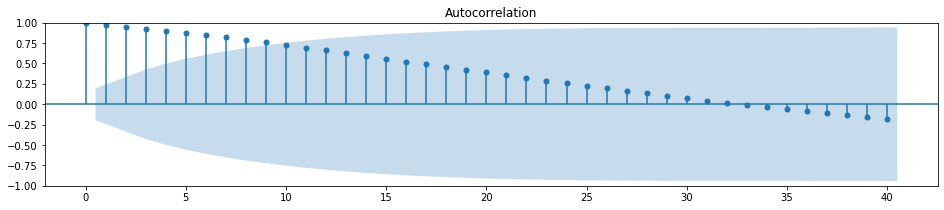

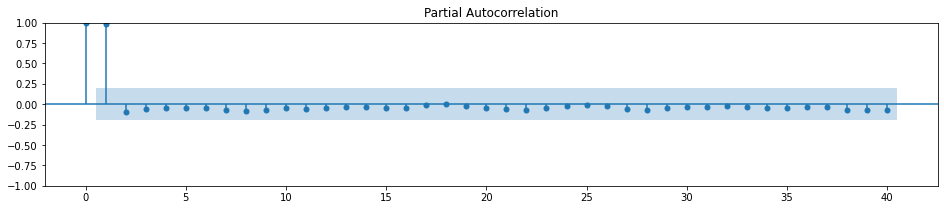

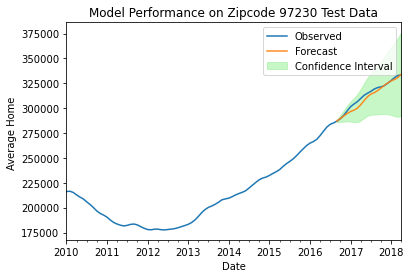

The RMSE of our test predictions is 3413.31
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6808      0.100      6.836      0.000       0.486       0.876
ma.L1          0.6983      0.090      7.795      0.000       0.523       0.874
ma.S.L12      -0.1189      0.076     -1.568      0.117      -0.268       0.030
sigma2      5.301e+05    9.8e+04      5.411      0.000    3.38e+05    7.22e+05


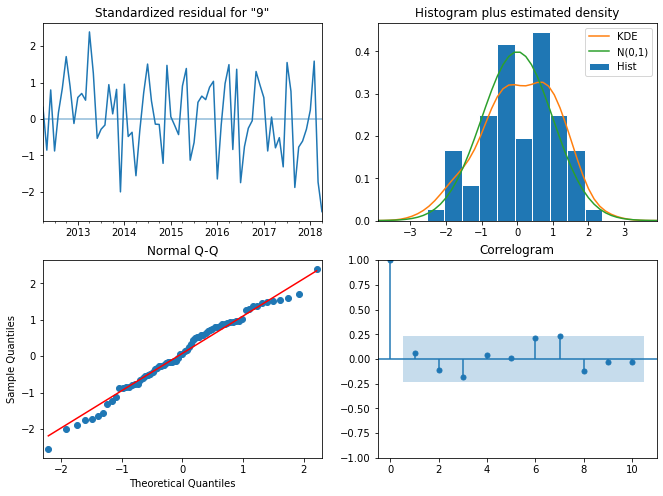

Projected 3 year ROI: 0.1427


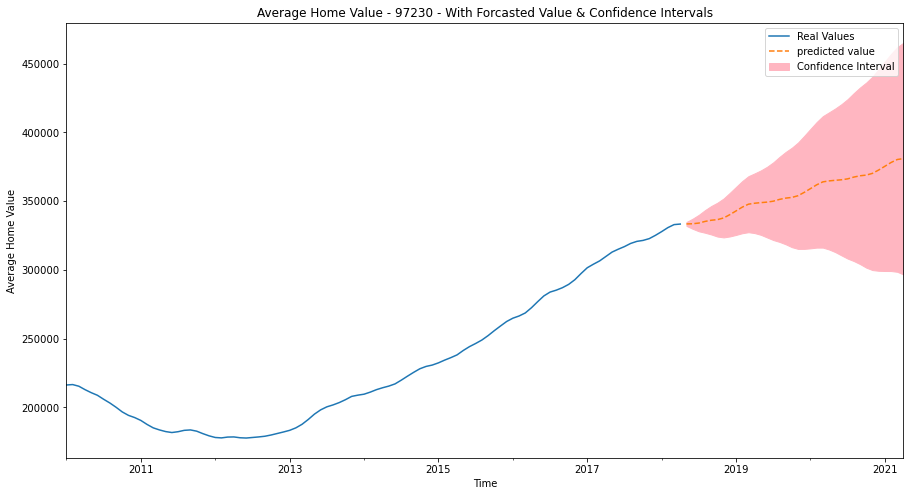

In [47]:
# Analyzing zipcode 97230

analyze_zipcode('97230')

### Zipcode 97230 Analysis Observations:

* Plot diagnostics show our model has adequately captured the time series data. Our residuals have a mean of zero and have uniform variance. Our density plot and Q-Q plot indicate that our residuals show a close to a normal distribution. Our correlogram indicates low correlation between the residuals and their lagged versions, which is great. These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.



* Model projection on our test data, with a RMSE of $3,413 confirms that our model is accurately capturing the data. Additionally, the actual values of our test data were captured in the confidence interval of our predictions.


* Projected 3 year ROI: **14 percent**

## Zipcode 83864: Schweitzer

Time Series Analysis of Zipcode 83864
pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           796.599
Name: 59, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6831      0.118      5.774      0.000       0.451       0.915
ma.L1          0.6040      0.126      4.779      0.000       0.356       0.852
ma.S.L12      -0.1591      0.095     -1.680      0.093      -0.345       0.027
sigma2      1.654e+05   3.74e+04      4.422      0.000    9.21e+04    2.39e+05


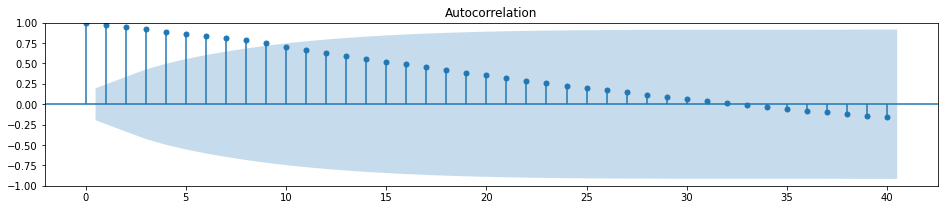

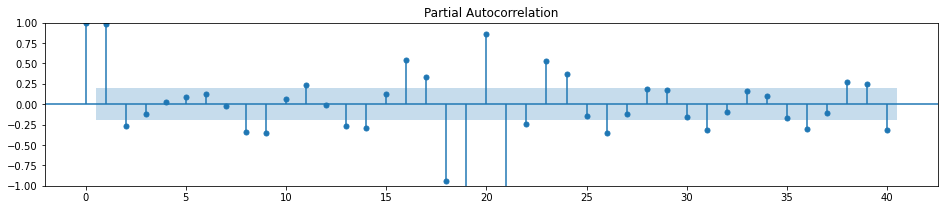

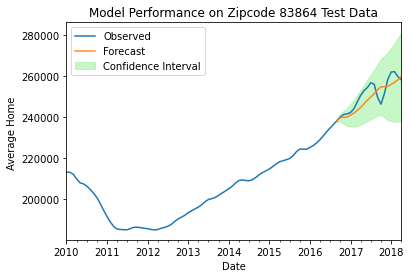

The RMSE of our test predictions is 4395.62
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4564      0.079      5.789      0.000       0.302       0.611
ma.L1          0.8673      0.076     11.348      0.000       0.718       1.017
ma.S.L12       0.1109      0.192      0.578      0.563      -0.265       0.487
sigma2      1.248e+06   1.68e+05      7.437      0.000    9.19e+05    1.58e+06


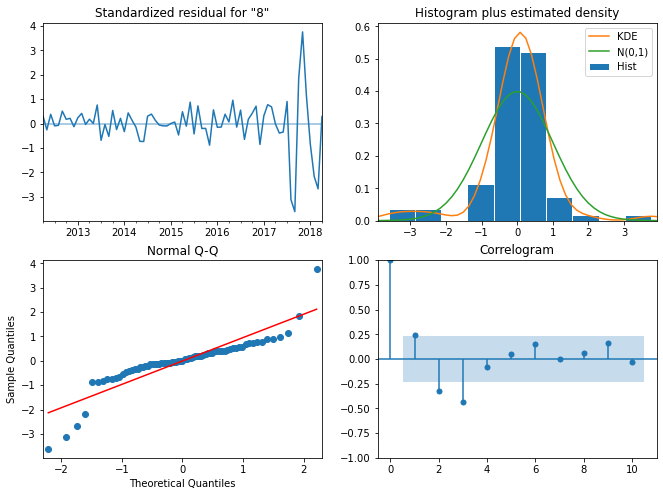

Projected 3 year ROI: 0.0206


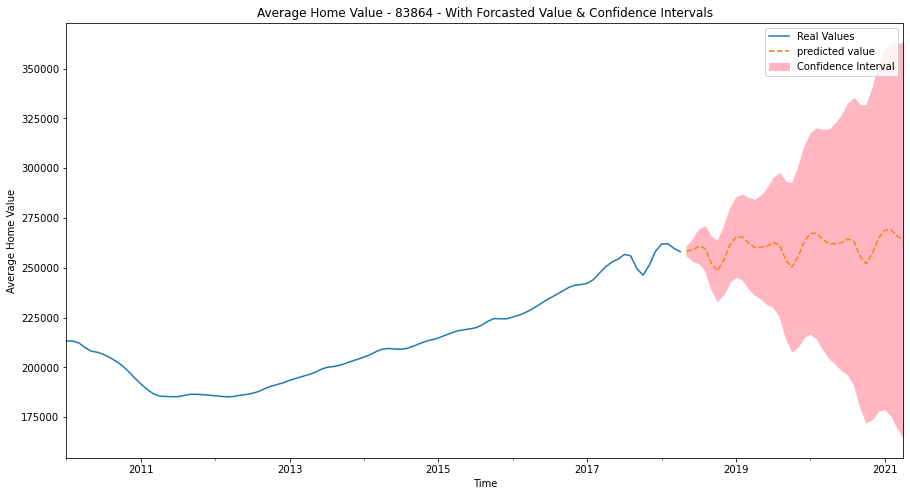

In [48]:
analyze_zipcode('83864')

### Zipcode 83864 Analysis Observations:

* Plot diagnostics show our model has adequately captured the time series data. Our residuals show a mean of zero with uniform variance. Additionally, our density plot and Q-Q plot indicate that our residuals nearly follow a normal distribution. Our correlogram shows some correlation with our residuals and their lagged values.



* Model projection on our test data, with a RMSE of $4,395, was accurate capturing the upward trend of the time series. Additionally, the actual values of our test data were captured in the confidence interval of our predictions.


* Projected 3 year ROI: **2 percent**

## Zipcode 95728: Northstar California

Time Series Analysis of Zipcode 95728
pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           1039.13
Name: 63, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6332      0.219      2.888      0.004       0.203       1.063
ma.L1          0.1788      0.090      1.986      0.047       0.002       0.355
ar.S.L12      -0.5221      0.268     -1.947      0.052      -1.048       0.004
ma.S.L12      -0.0223      0.249     -0.090      0.928      -0.510       0.465
sigma2      2.166e+07   2.21e-09   9.81e+15      0.000    2.17e+07    2.17e+07


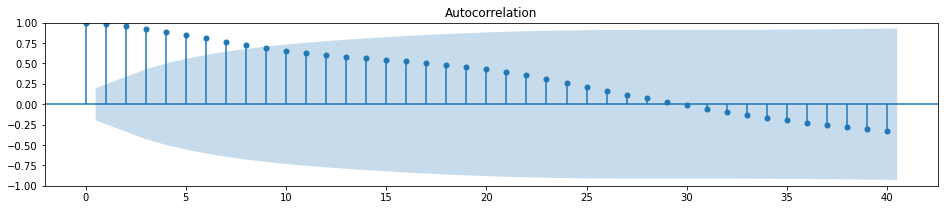

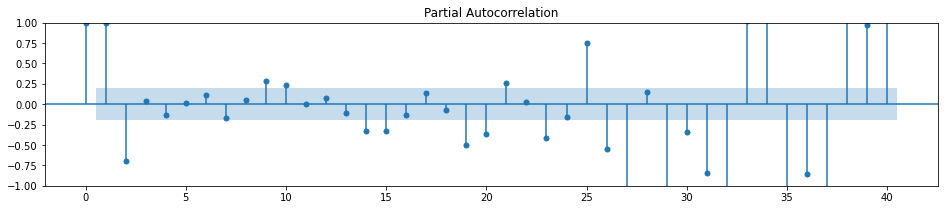

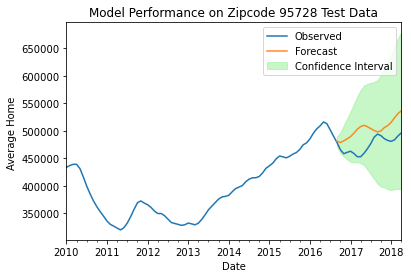

The RMSE of our test predictions is 32535.54
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6863      0.134      5.127      0.000       0.424       0.949
ma.L1          0.1976      0.056      3.553      0.000       0.089       0.307
ar.S.L12      -0.5776      0.207     -2.789      0.005      -0.983      -0.172
ma.S.L12      -0.0217      0.190     -0.114      0.909      -0.394       0.350
sigma2       2.46e+07   2.08e-09   1.18e+16      0.000    2.46e+07    2.46e+07


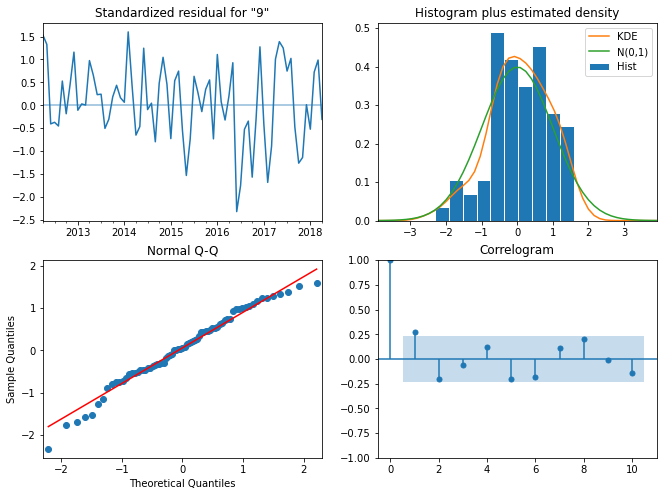

Projected 3 year ROI: 0.0099


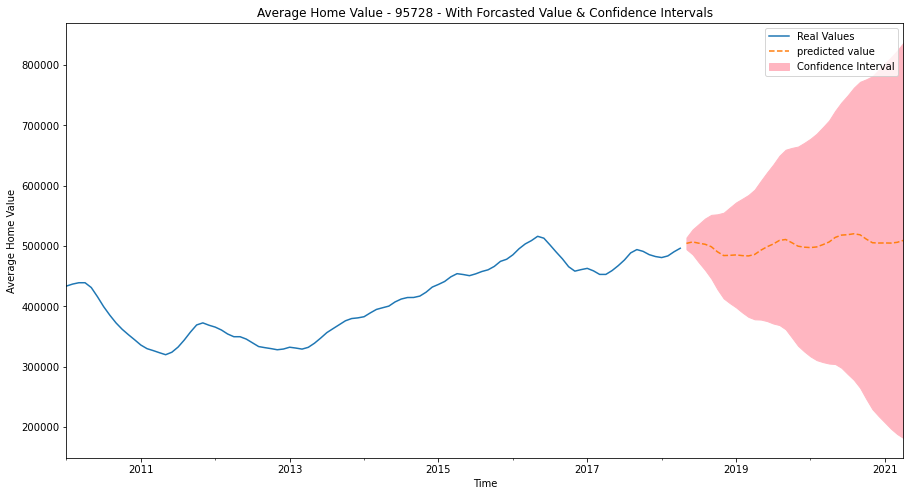

In [49]:
analyze_zipcode('95728')

### Zipcode 95728 Analysis Observations:

* Plot diagnostics show our model has adequately captured the time series data. Our residuals have a mean of zero, uniform variance and don't show any obvious seasonality over time. Our density plot and Q-Q plot indicate that our residuals nearly follow a normal distribution. Our correlogram shows low correlation between the residuals and their lagged versions, which is great. These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.



* Model projection on our test data, with a RMSE of $32,535, was not a perfect fit but does capture the overall trend of the time series. Additionally, the actual values of our test data were captured in the confidence interval of our predictions.


* Projected 3 year ROI: **1 percent**

## Zipcode 97701: Mt. Bachelor

Time Series Analysis of Zipcode 97701
pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           848.753
Name: 59, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7727      0.073     10.523      0.000       0.629       0.917
ma.L1          0.8467      0.063     13.512      0.000       0.724       0.969
ma.S.L12      -0.2074      0.060     -3.440      0.001      -0.326      -0.089
sigma2      3.609e+05   7.21e+04      5.008      0.000     2.2e+05    5.02e+05


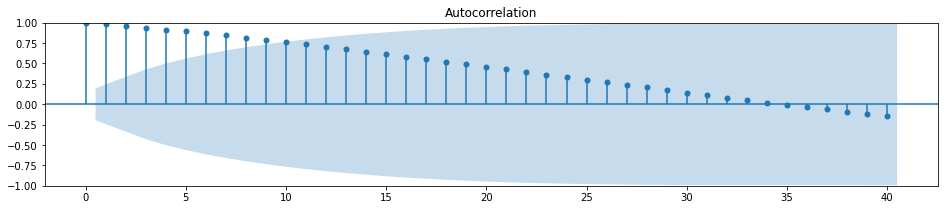

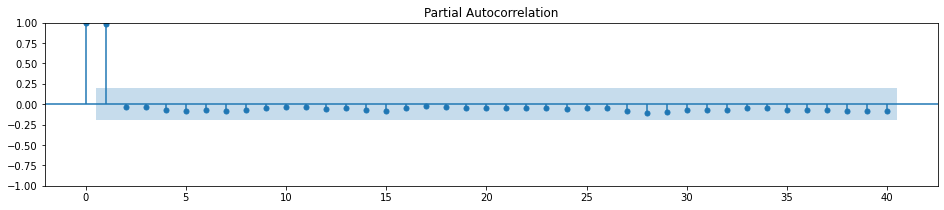

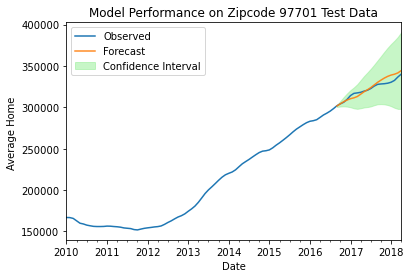

The RMSE of our test predictions is 4410.1
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6895      0.070      9.815      0.000       0.552       0.827
ma.L1          0.8184      0.069     11.893      0.000       0.684       0.953
ma.S.L12      -0.1799      0.054     -3.345      0.001      -0.285      -0.074
sigma2       5.34e+05   9.24e+04      5.778      0.000    3.53e+05    7.15e+05


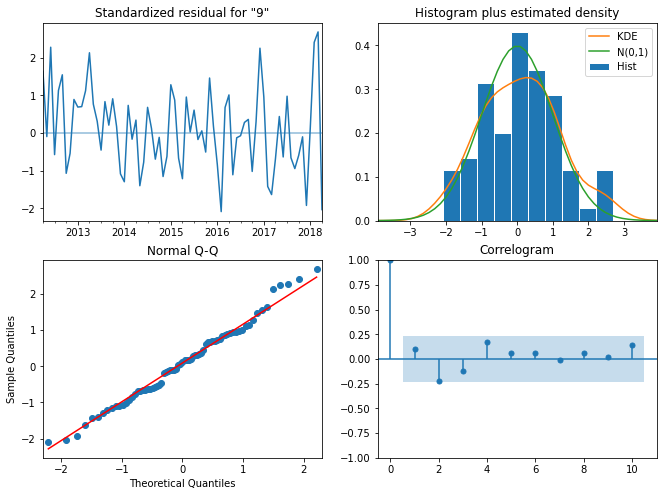

Projected 3 year ROI: 0.2109


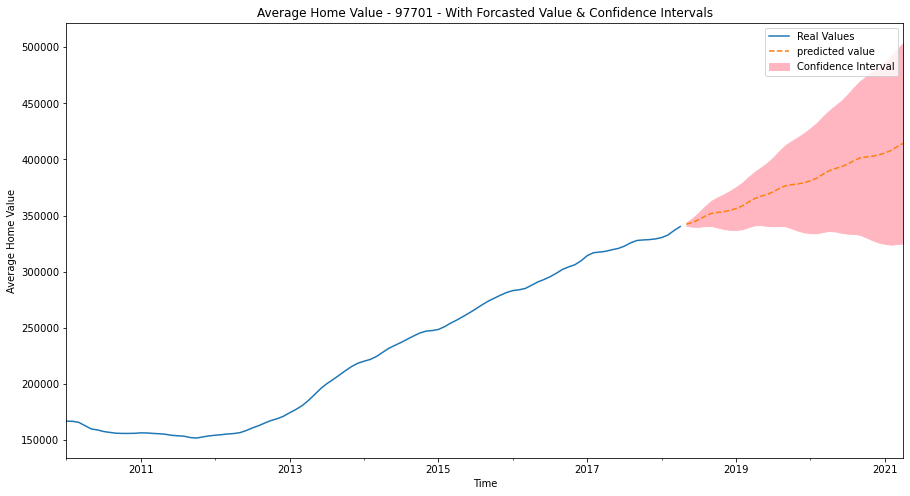

In [50]:
analyze_zipcode('97701')

## Zipcode 97701 Analysis Observations:

* Plot diagnostics show our model has adequately captured the time series data. Our residuals have a mean of zero, uniform variance and don't show any obvious seasonality over time. Our density plot and Q-Q plot indicate that our residuals nearly follow a normal distribution. Our correlogram shows low correlation between the residuals and their lagged versions, which is great. These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.



* Model projection on our test data, with a RMSE of $4,410, captured the time series accurately. Additionally, the actual values of our test data were captured in the confidence interval of our predictions. 


* Projected 3 year ROI: **21 percent**

# Recommendations:

Now that we have analyzed each time series let's visualize all the top 5 zip codes and their respective projected three-year return on investment.

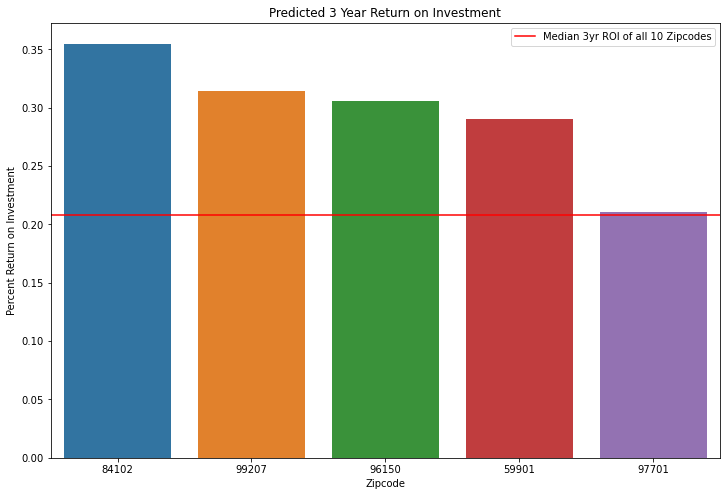

In [51]:
# Viewing top 5 zipcodes based on 3 yr ROI

import seaborn as sns

results = pd.DataFrame(results, columns=('Zipcode', '3yrROI'))
top_5_zipcodes = results.sort_values(by='3yrROI', ascending=False).head(5)

fig, ax = plt.subplots(figsize=(12, 8))
graph = sns.barplot(x=top_5_zipcodes['Zipcode'], y=top_5_zipcodes['3yrROI'], ax=ax)
graph.axhline(results['3yrROI'].median(), color='red', label='Median 3yr ROI of all 10 Zipcodes')
ax.set_title('Predicted 3 Year Return on Investment')
ax.set_ylabel('Percent Return on Investment')
ax.legend();

Our time series analysis produced the following 5 zip codes that we recommend to the client for investment opportunities. Our model predicted zip code 84102, located in Salt Lake City and near Alta Ski Resort, as the most fruitful investment. The projected 3-year return on investment for all zip codes in our top 5 is greater than 20 percent and most (except zipcode 97701) are well above the median 3-year ROI of all other zip codes we performed modeling on. 

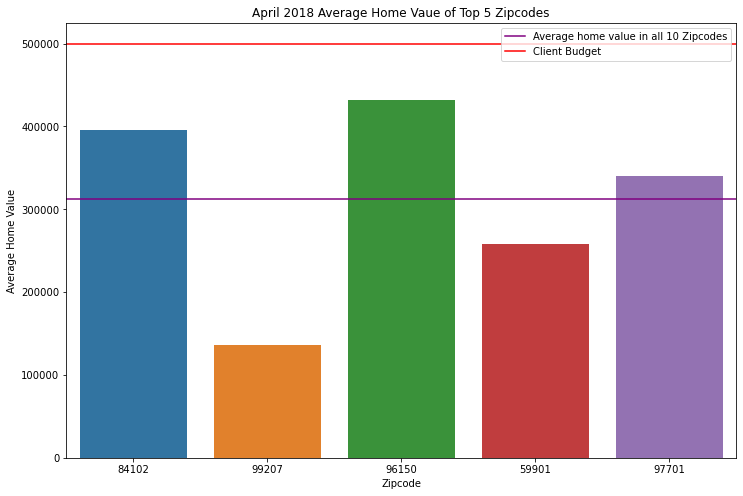

In [75]:
final_df['RegionName'] = final_df['RegionName'].astype(str)
final_zips = pd.merge(final_df, top_5_zipcodes,  how='left', left_on=['RegionName'], right_on = ['Zipcode'])
housing_price = final_zips.sort_values('3yrROI', ascending=False).head(5)

fig, ax = plt.subplots(figsize=(12, 8))
graph = sns.barplot(x=housing_price['RegionName'], y=housing_price['2018-04'], ax=ax)
graph.axhline(housing_price['2018-04'].mean(), color='purple', label='Average home value in all 10 Zipcodes')
graph.axhline(500000, color='red', label='Client Budget')
ax.set_title('April 2018 Average Home Vaue of Top 5 Zipcodes')
ax.set_ylabel('Average Home Value')
ax.set_xlabel('Zipcode')
ax.legend(loc='best');


Zipcode 99207, located in Spokane WA, and near 49 Degrees North, had the cheapest average home value in our top 5 zip codes. This zip code was also projected to have the second-highest 3-year ROI, which is great! Zip code 59901 was also well beneath the average home value of all other zip codes that were analyzed. The three remaining were above average. 

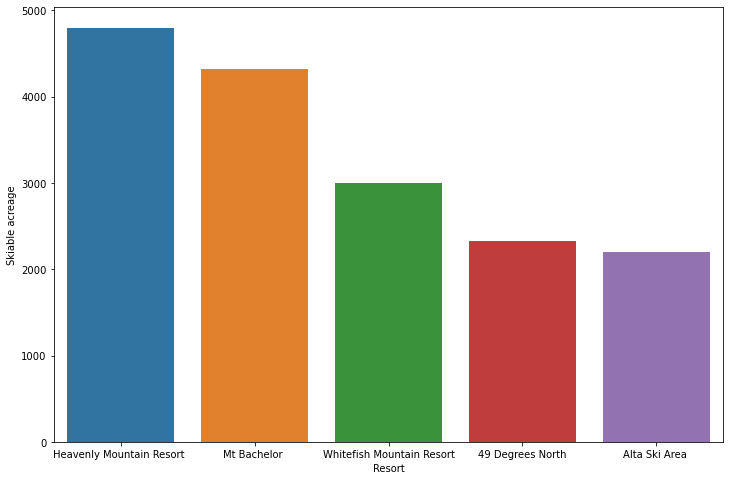

In [53]:
# Combing top 5 zipcodes and resorts dataframes 

resorts_df['RegionName'] = resorts_df['RegionName'].astype(str)
final_resorts = pd.merge(resorts_df, top_5_zipcodes,  how='left', left_on=['RegionName'], right_on = ['Zipcode'])
final_resorts.dropna(inplace=True)
final_resorts = final_resorts[['RegionName', 'City', 'State', 'Resort', 'Skiable acreage', 'Avg annual snowfall (in)']]
final_resorts


# Viewing Top 5 Zicodes and their associated resort skiable acreage 

fig, ax = plt.subplots(figsize=(12, 8))
final_resorts = final_resorts.sort_values('Skiable acreage', ascending=False)
sns.barplot(x=final_resorts['Resort'], y=final_resorts['Skiable acreage'], ax=ax)
plt.title('');

Our client would like to know how the top 5 zip codes ranked in skiable acreage. Heavenly Mountain Resort tops the list.

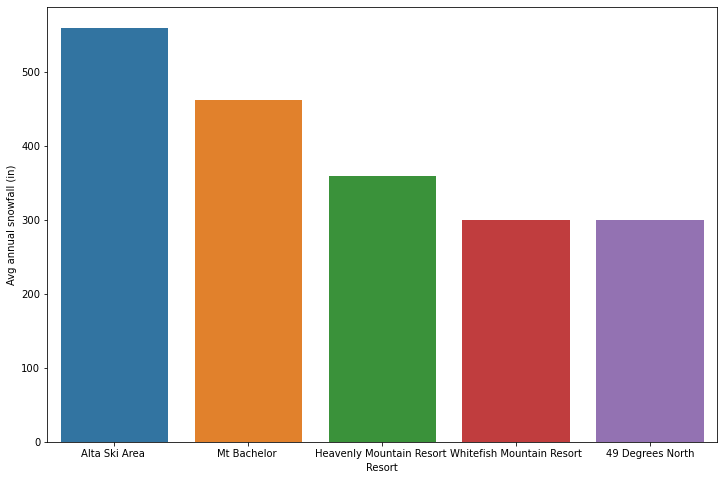

In [54]:
# Viewing Top 5 Zicodes and their associated resorts annual average snowfall

fig, ax = plt.subplots(figsize=(12, 8))
final_resorts = final_resorts.sort_values('Avg annual snowfall (in)', ascending=False)
sns.barplot(x=final_resorts['Resort'], y=final_resorts['Avg annual snowfall (in)'], ax=ax);

Our client would also like to know what ski resort in our top 5 zip codes experiences the most snow. That would be Alta Ski Area.

Our time series analysis produced the following 5 zip codes that we recommend to the client for investment opportunities. We have ranked them based on highest three year return on investment projections and provided ski resort metrics of interest.

## #1 Salt Lake City, UT: Zipcode 84102

### 3 Year ROI - 35.48%

Resort: **Alta Ski Area**

Skiable acerage: **2,200**

Average annual snowfall (in): **560** 

## #2 Spokane, WA: Zipcode 99207

### 3 Year ROI - 31.39%

Resort: **49 Degrees North**

Skiable acerage: **2,325**

Average annual snowfall (in): **300**


## #3 South Lake Tahoe, CA: Zipcode 96150

### 3 Year ROI - 30.57%

Resort: **Heavenly Mountain Resort**

Skiable acerage: **4,800**

Average annual snowfall (in): **360**

## #4 Kalispell, MT: Zipcode 59901

### 3 Year ROI - 29.06%

Resort: **Whitefish Mountain Resort**

Skiable acerage: **3,000**

Average annual snowfall (in): **300** 

## #5 Bend, OR: Zipcode 97701

### 3 Year ROI - 21.09%

Resort: **Mt. Bachelor**

Skiable acerage: **4,318**

Average annual snowfall (in): **462**

# Conclusion

This analysis was meant to provide our clients with options for smart real estate investment opportunities in areas where they can enjoy their favorite pass time, skiing. We believe that the recommended areas put forth through this modeling process can help them to accomplish this goal. While time series modeling is not a flawless method of predictive power, it provides us with more confidence in our decision-making when trying to make good investments. Choosing which zipcode to eventually invest in will be left to the client to decide based on personal preference.

# Limitations and Future Analysis

1. A limitation of this analysis that was encountered was the omission of resorts that were near cities not recorded or recognized in our Zillow dataset. This means that it is certainly possible for there to be additional zipcodes that fit our client's criteria that were not captured during our data filtering procedures. Finding a more robust dataset that contains zip codes and all of their associated cities/towns could help with this issue.


2. Exploring other exogenous features that contribute to the home value volatility of resort towns may help to better understand correlations within the data. These could include work-from-home opportunities, job markets, and weather.


3. The Zillow dataset used for this analysis had its most recent data points in April 2018. Finding more recent data will allow us to more accurately forecast future home value into 2025 and beyond.

## 